# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 21

In [2]:
cluster = '21'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 681
Num noneffect sequences: 681


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  \
499   chr2  127117807  127117808   rs34745987      T         C   C   
239  chr17   45903631   45903632  rs112003140      G         A   G   
623   chr4   89836583   89836584    rs2619361      C         A   C   
153  chr17   45681520   45681521   rs76539714      G         A   A   
547   chr3  122458998  122458999   rs56118506      T         C   C   
196  chr17   45848599   45848600   rs62054817      G         A   G   
503   chr2  127128581  127128582   rs13025717      T         C   C   
336  chr17   46130520   46130521   rs10514904      T         C   C   
625   chr4   89837895   89837896    rs2619363    NAN       NAN   G   
604   chr4   89829436   89829437    rs2583979      T         A   A   
467  chr19   45326535   45326536     rs344791      C         G   G   
423  chr19   44890258   44890259  rs117310449      T         C   C   
29   chr11   47373688   47373689    rs7940536      A         G   G   
591   chr4   89818510   89818511    rs2737022      A         C   A   
643   chr6   27772520   27772521     rs760587      C         A   C   
205  chr17   45852871   45852872   rs79589869      C         A   C   
411  chr19   44644418   44644419   rs10426401      T         G   T   
60   chr11   86148440   86148441   rs10898439      G         C   G   
343  chr17   46130945   46130946    rs6503457      T         G   G   
190  chr17   45827030   45827031   rs17689824      T         C   C   
218  chr17   45882974   45882975   rs56127309      G         A   G   
405  chr19   18462023   18462024    rs8103622      T         C   C   
109  chr16   31117346   31117347   rs12716982      C         A   C   
528   chr3   49007333   49007334    rs6781790      T         C   C   
242  chr17   45914204   45914205  rs141801658      I         D   G   
67   chr12   40224294   40224295    rs1388597      G         A   A   
173  chr17   45783750   45783751   rs62057073      T         C   C   
414  chr19   44747898   44747899    rs2965169      C         A   A   
128  chr17    4901871    4901872   rs79436576      T         C   C   
156  chr17   45688014   45688015   rs77310586      G         C   G   
..     ...        ...        ...          ...    ...       ...  ..   
455  chr19   44989300   44989301   rs11669173      G         A   G   
582   chr4   89771316   89771317     rs356187      T         C   T   
525   chr3   48898149   48898150    rs7431710      G         A   G   
470   chr2   95071933   95071934    rs4854244      C         A   A   
669   chr8   22623005   22623006   rs11780207      G         A   G   
544   chr3   52671091   52671092  rs149085395      T         C   C   
152  chr17   45681518   45681519  rs112431991      G         A   A   
137  chr17    5111493    5111494   rs56229705      A         G   G   
527   chr3   48948965   48948966   rs13315711      T         A   A   
365  chr17   75011885   75011886   rs35303667      A         T   T   
629   chr5   60768557   60768558    rs9291696      T         C   C   
231  chr17   45896046   45896047   rs78720789      G         A   A   
136  chr17    4909107    4909108   rs16954243      T         A   A   
459  chr19   45045876   45045877  rs112481437      A         G   G   
502   chr2  127118665  127118666   rs71414738      T         C   C   
358  chr17   46287462   46287463    rs2732613      A         C   A   
497   chr2  127107527  127107528  2_127107528    NAN       NAN   .   
271  chr17   45949128   45949129   rs74531363      G         A   A   
151  chr17   45681423   45681424   rs62055702      T         C   C   
535   chr3   52308077   52308078  rs145746673      G         C   G   
550   chr3  151383902  151383903   rs10935841      T         C   C   
532   chr3   52237762   52237763  rs146527642      G         C   G   
312  chr17   46059396   46059397   rs62060786      T         C   C   
82   chr14   74713030   74713031    rs2270425      G         C   C   
106  chr16   31093556   31093557    rs9934438      G         A   G   
269  chr17   4594

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs34745987   ||    chr2 : 127117807 - 127117808   ||    Locus: 499   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.40E-10
Alzheimers_Lambert_2013 	  3.86E-08

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.4381   ||   Center / 200bp : 0.3086
Noneffect Sequence : ACAGACACGCGCAGTTGTCA


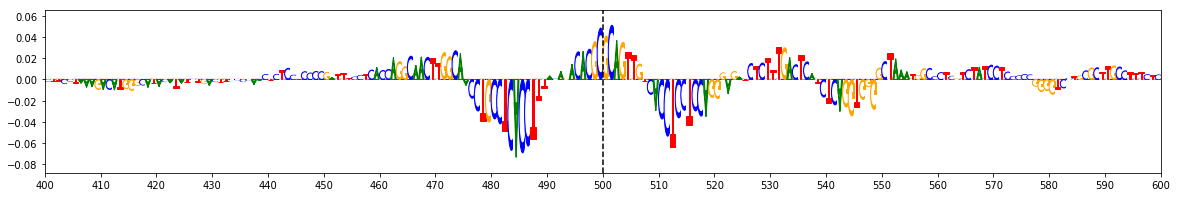

Effect Allele : T   ||   Explain Score : 0.0564   ||   Center / 200bp : 0.0543
Effect Sequence : ACAGACACGTGCAGTTGTCA


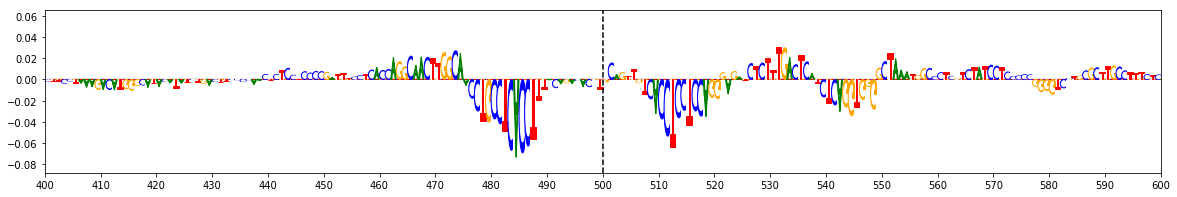

Allele Ratio : 0.1286   ||   Allele Difference : -0.4514  ||  ISM Score : -0.7066  ||  deltaSVM Score : -4.0534


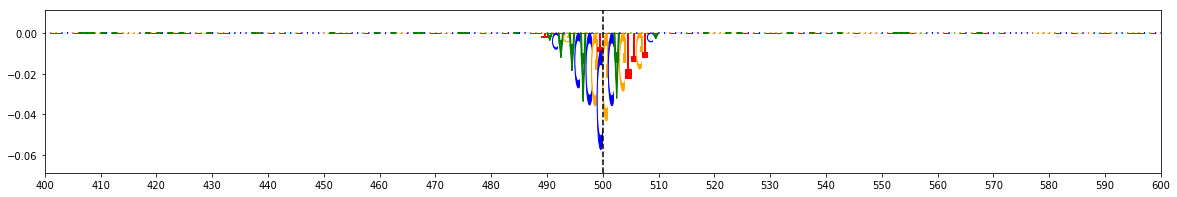


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs112003140   ||    chr17 : 45903631 - 45903632   ||    Locus: 239   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.2039   ||   Center / 200bp : 0.2068
Noneffect Sequence : GGGAATGGCATGAACCCGGG


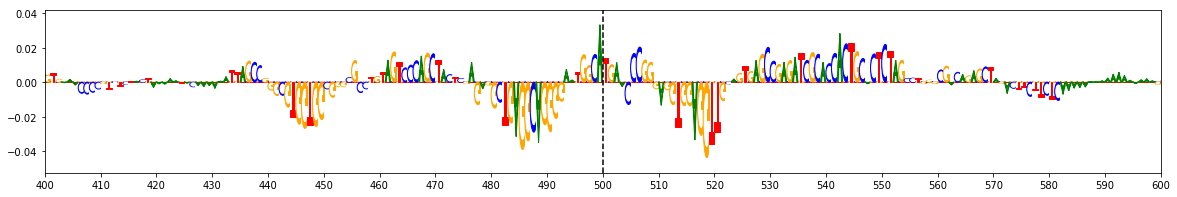

Effect Allele : G   ||   Explain Score : 0.0243   ||   Center / 200bp : 0.0301
Effect Sequence : GGGAATGGCGTGAACCCGGG


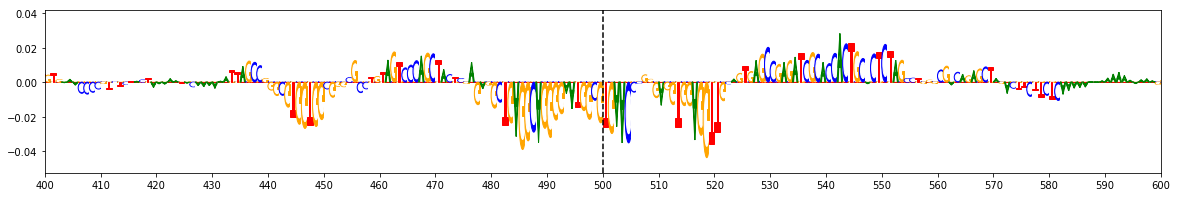

Allele Ratio : 0.1189   ||   Allele Difference : -0.4493  ||  ISM Score : -0.8009  ||  deltaSVM Score : -4.5945


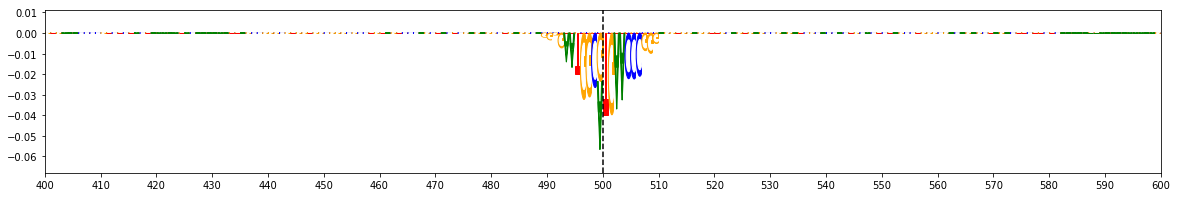


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 623   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.334   ||   Center / 200bp : 0.2887
Noneffect Sequence : GTCTCTTTCATTAGGCTCCC


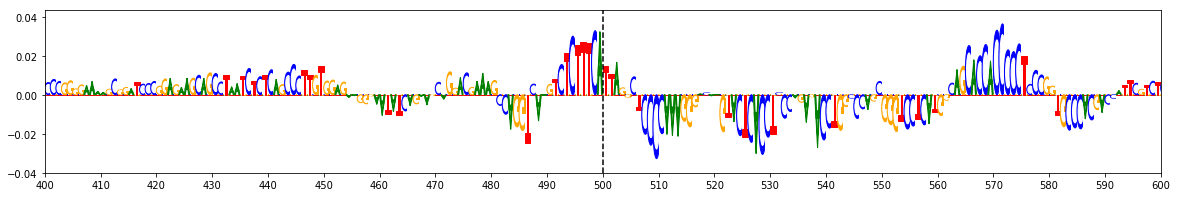

Effect Allele : C   ||   Explain Score : 0.0624   ||   Center / 200bp : 0.0704
Effect Sequence : GTCTCTTTCCTTAGGCTCCC


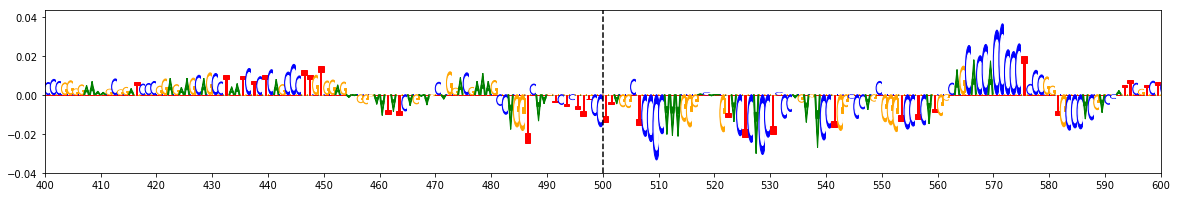

Allele Ratio : 0.1869   ||   Allele Difference : -0.3831  ||  ISM Score : -0.5989  ||  deltaSVM Score : -3.4757


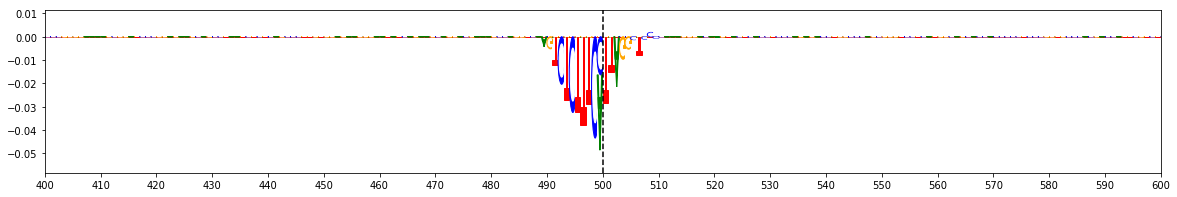


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76539714   ||    chr17 : 45681520 - 45681521   ||    Locus: 153   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.08E-23

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.1357   ||   Center / 200bp : 0.1933
Noneffect Sequence : CCTCCTCAAACTGAAACCCC


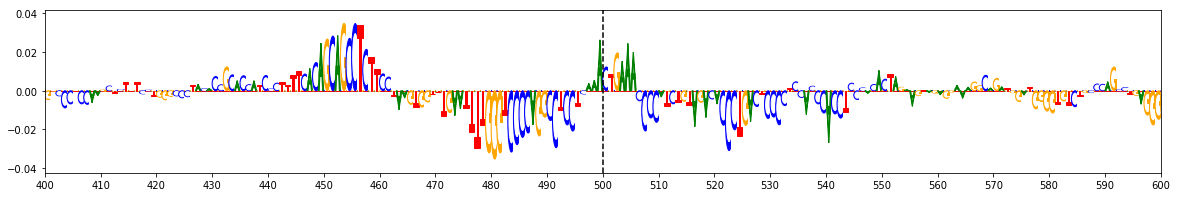

Effect Allele : G   ||   Explain Score : 0.0171   ||   Center / 200bp : 0.0294
Effect Sequence : CCTCCTCAAGCTGAAACCCC


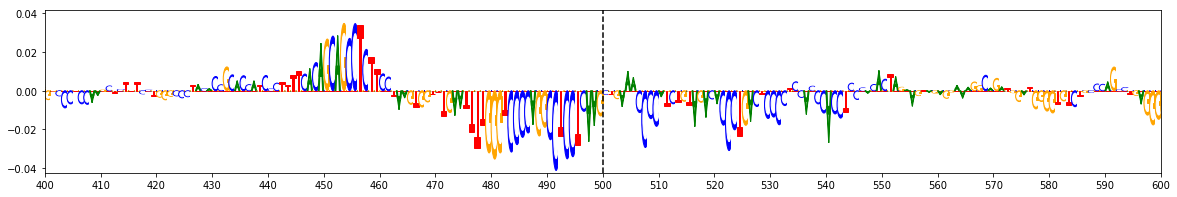

Allele Ratio : 0.1263   ||   Allele Difference : -0.3096  ||  ISM Score : -0.4871  ||  deltaSVM Score : -2.8323


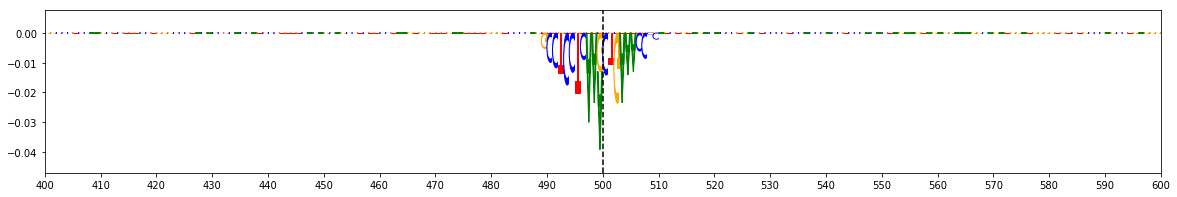


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56118506   ||    chr3 : 122458998 - 122458999   ||    Locus: 547   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  5.45E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.5962   ||   Center / 200bp : 0.468
Noneffect Sequence : TTATCACTTCCGGAGGAATC


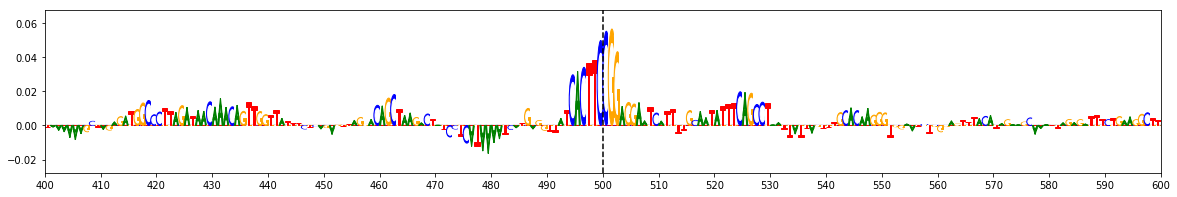

Effect Allele : T   ||   Explain Score : 0.1929   ||   Center / 200bp : 0.2217
Effect Sequence : TTATCACTTTCGGAGGAATC


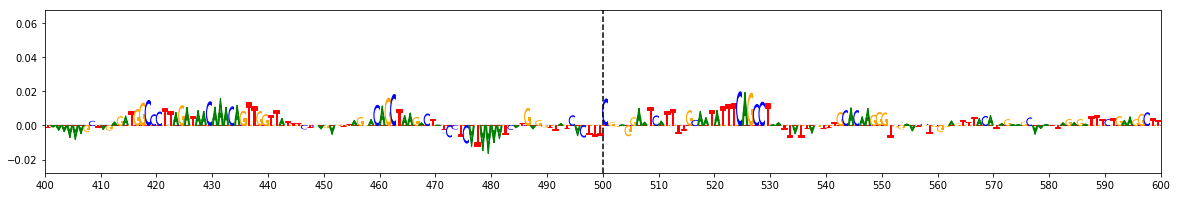

Allele Ratio : 0.3235   ||   Allele Difference : -0.4361  ||  ISM Score : -0.6804  ||  deltaSVM Score : -3.8752


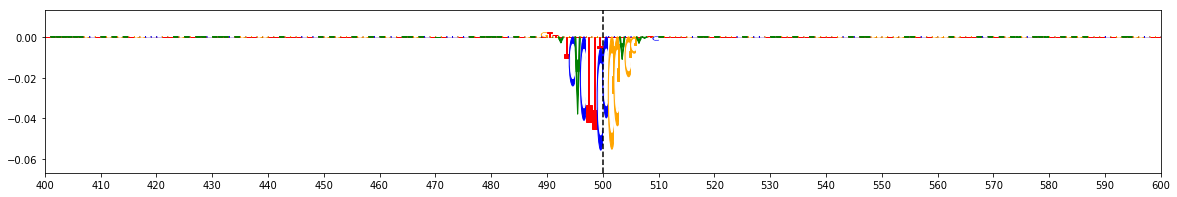


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054817   ||    chr17 : 45848599 - 45848600   ||    Locus: 196   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.14E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.8431   ||   Center / 200bp : 0.7461
Noneffect Sequence : ATCTTCCCCAGTAGAGGGCC


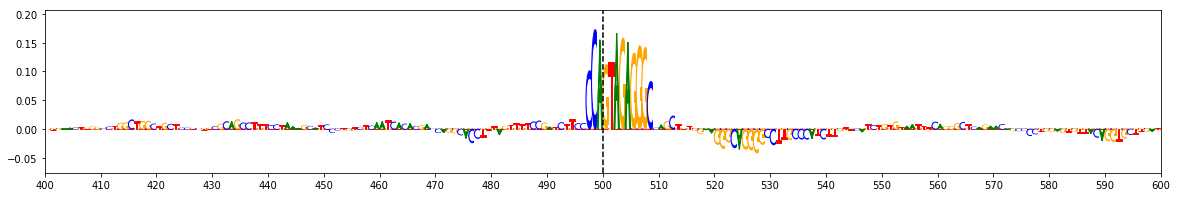

Effect Allele : G   ||   Explain Score : 0.951   ||   Center / 200bp : 0.6026
Effect Sequence : ATCTTCCCCGGTAGAGGGCC


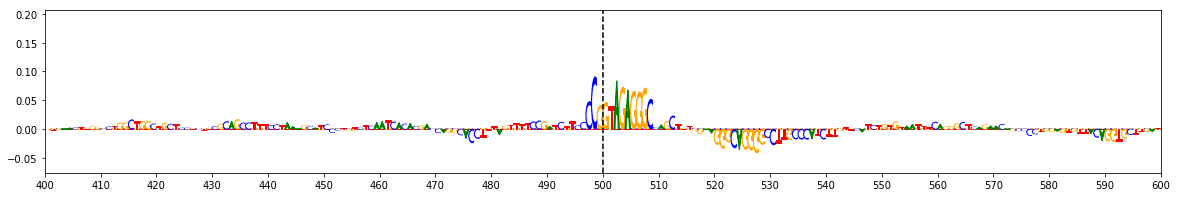

Allele Ratio : 0.516   ||   Allele Difference : -0.8921  ||  ISM Score : -1.4057  ||  deltaSVM Score : -8.0755


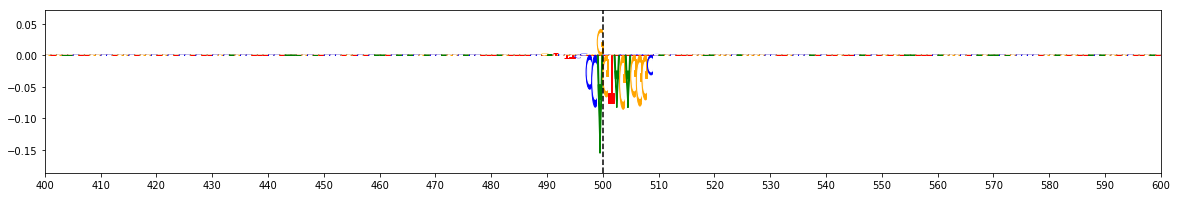


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 503   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0678   ||   Center / 200bp : 0.618
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


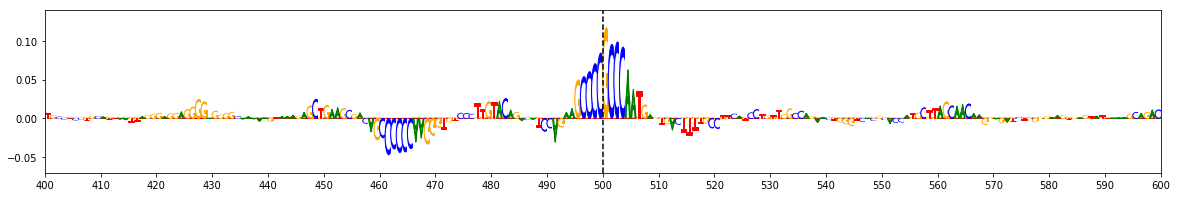

Effect Allele : T   ||   Explain Score : 0.4658   ||   Center / 200bp : 0.4139
Effect Sequence : CAGAAGCCCTGCCCAATGAG


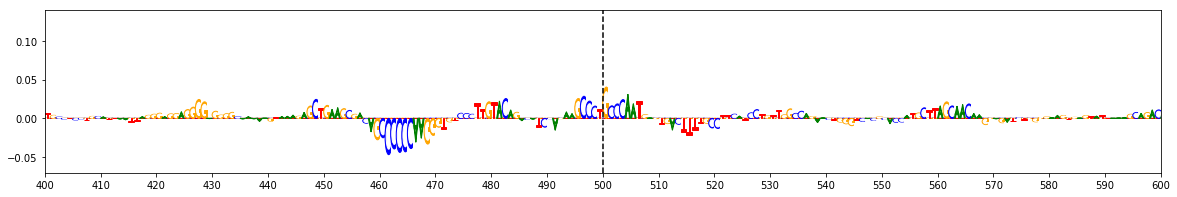

Allele Ratio : 0.4363   ||   Allele Difference : -0.5585  ||  ISM Score : -0.8707  ||  deltaSVM Score : -4.8882


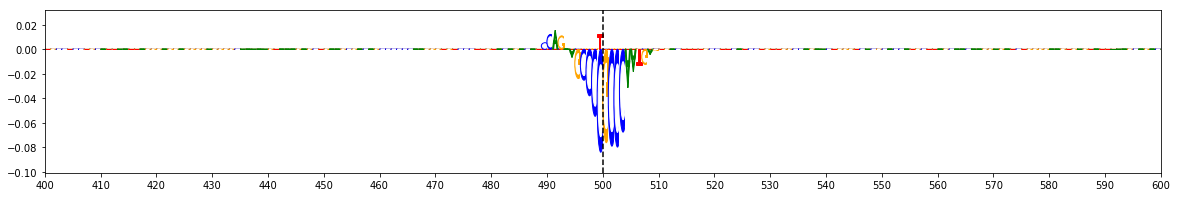


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10514904   ||    chr17 : 46130520 - 46130521   ||    Locus: 336   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.69E-22
Parkinsons_Pankratz_2012 	  4.90E-10

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8658   ||   Center / 200bp : 0.6109
Noneffect Sequence : TGTAAAAGGCTGTTTCATAC


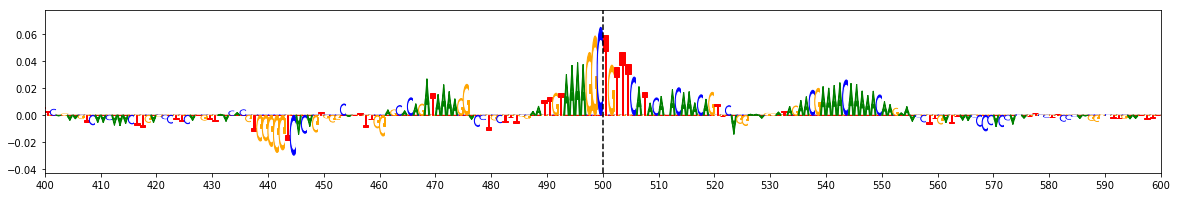

Effect Allele : T   ||   Explain Score : 0.3974   ||   Center / 200bp : 0.4189
Effect Sequence : TGTAAAAGGTTGTTTCATAC


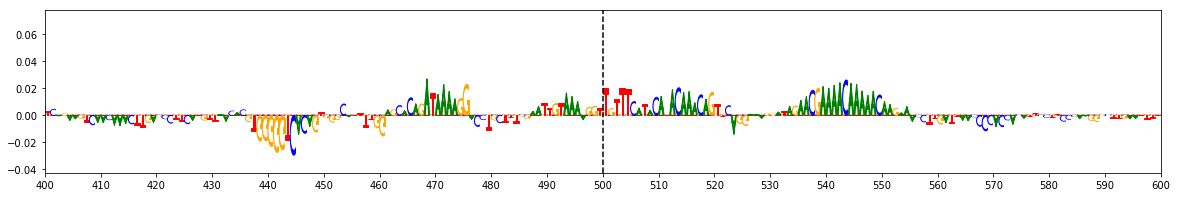

Allele Ratio : 0.459   ||   Allele Difference : -0.4716  ||  ISM Score : -0.7347  ||  deltaSVM Score : -4.2367


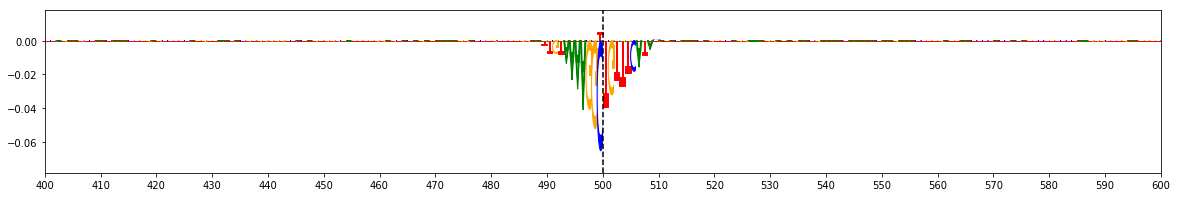


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 625   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.075   ||   Center / 200bp : 0.5289
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


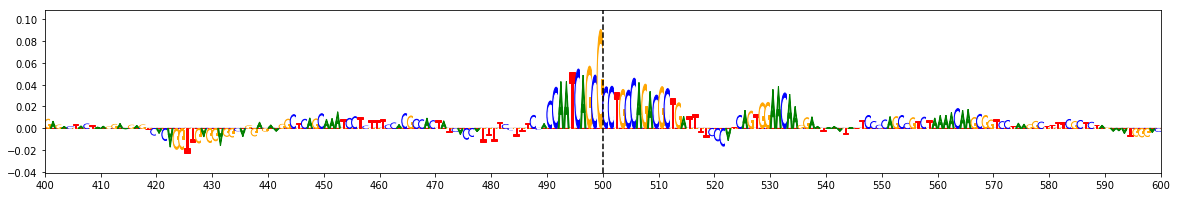

Effect Allele : NAN   ||   Explain Score : 0.4501   ||   Center / 200bp : 0.3181
Effect Sequence : CCAATCAGCCCCTGCCAGAC


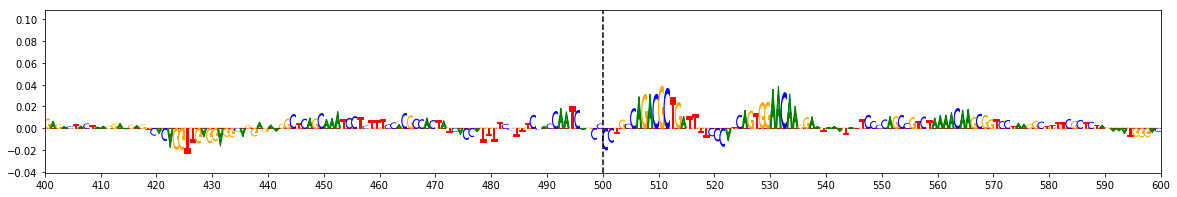

Allele Ratio : 0.4187   ||   Allele Difference : -0.6732  ||  ISM Score : -1.0275  ||  deltaSVM Score : -6.1344


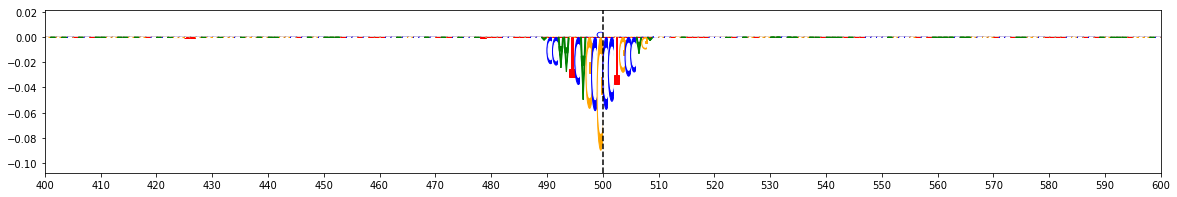


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2583979   ||    chr4 : 89829436 - 89829437   ||    Locus: 604   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  3.63E-14

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.562   ||   Center / 200bp : 0.514
Noneffect Sequence : TTTTCAGCAACACTTCCTCT


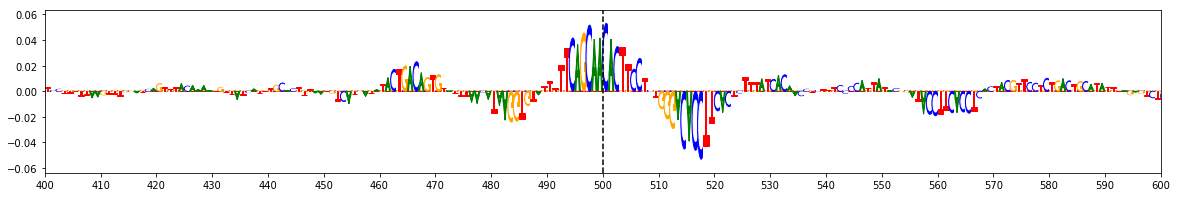

Effect Allele : T   ||   Explain Score : 0.2376   ||   Center / 200bp : 0.3094
Effect Sequence : TTTTCAGCATCACTTCCTCT


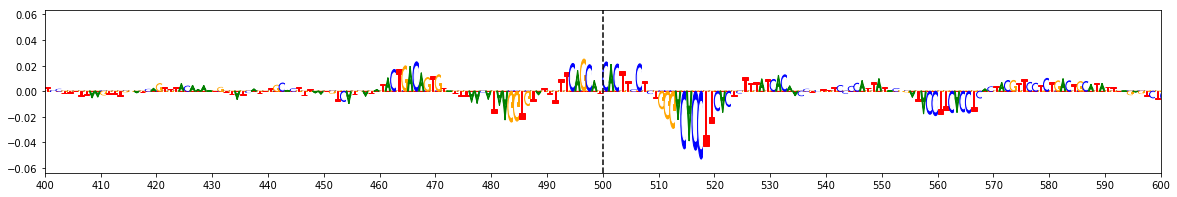

Allele Ratio : 0.4228   ||   Allele Difference : -0.339  ||  ISM Score : -0.5342  ||  deltaSVM Score : -3.0837


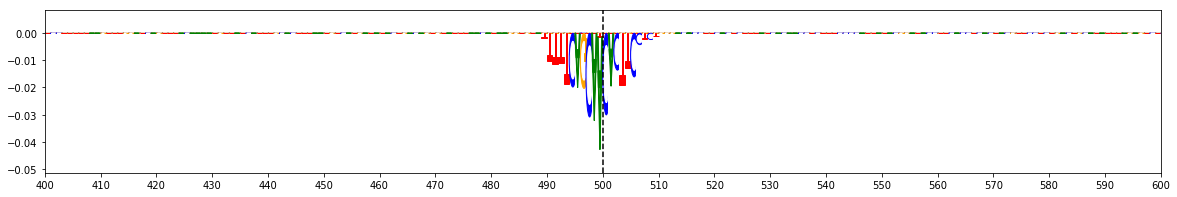


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 467   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3856   ||   Center / 200bp : 0.5263
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


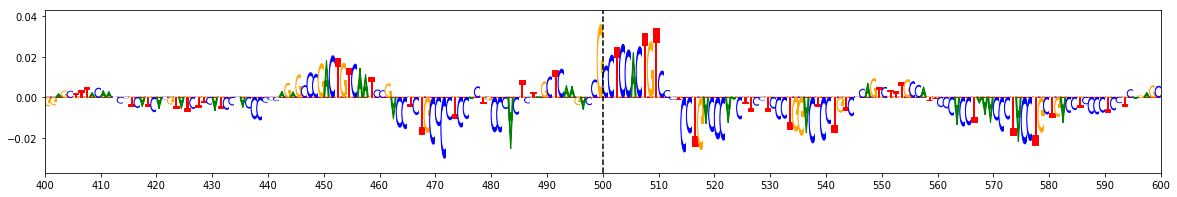

Effect Allele : C   ||   Explain Score : 0.177   ||   Center / 200bp : 0.3402
Effect Sequence : CTCAAGACCCCCTCCACTGT


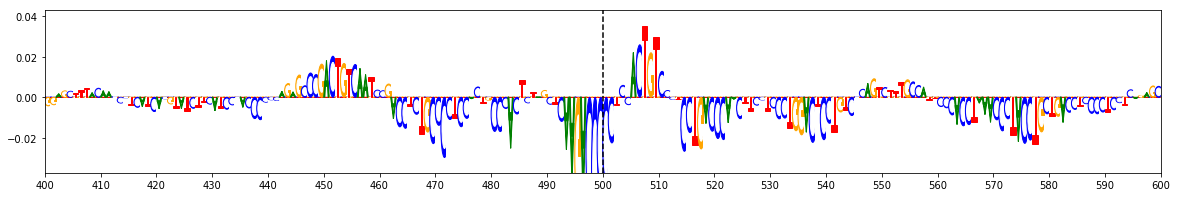

Allele Ratio : 0.4591   ||   Allele Difference : -0.6439  ||  ISM Score : -1.0274  ||  deltaSVM Score : -5.9455


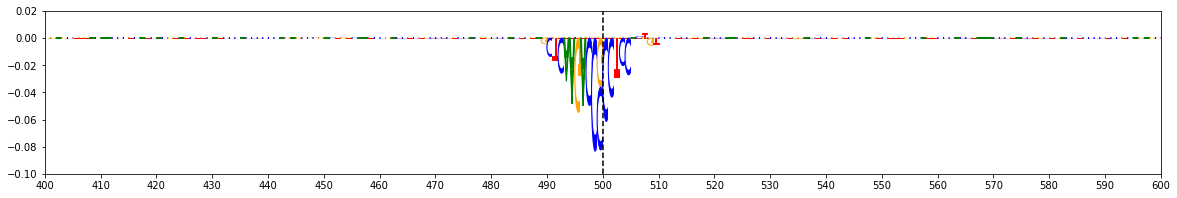


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 423   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.04E-94
Alzheimers_Kunkle_2019 		  2.28E-46
Alzheimers_Lambert_2013 	  3.69E-36

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.7439   ||   Center / 200bp : 0.608
Noneffect Sequence : GGCCAGAGGCAGAGTGATGA


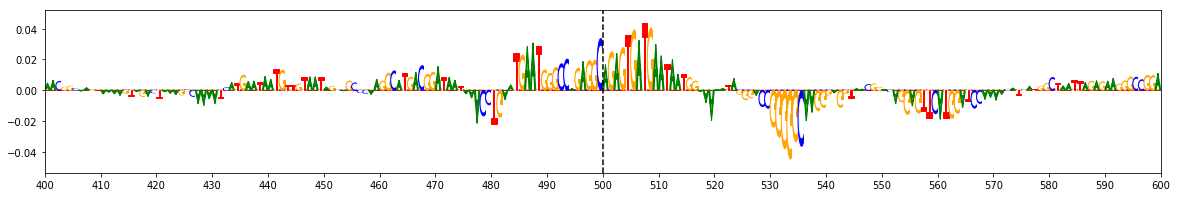

Effect Allele : T   ||   Explain Score : 0.4045   ||   Center / 200bp : 0.4573
Effect Sequence : GGCCAGAGGTAGAGTGATGA


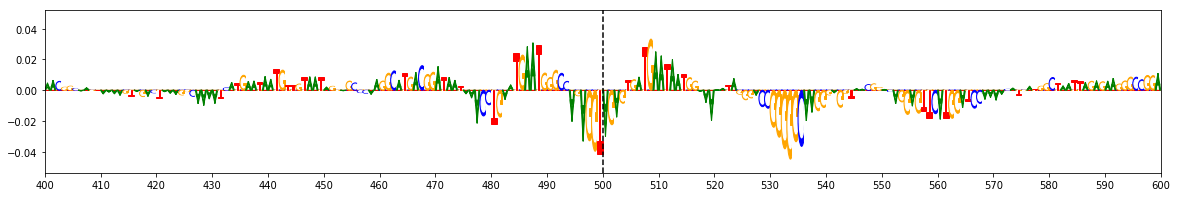

Allele Ratio : 0.5438   ||   Allele Difference : -0.5897  ||  ISM Score : -0.9366  ||  deltaSVM Score : -5.3551


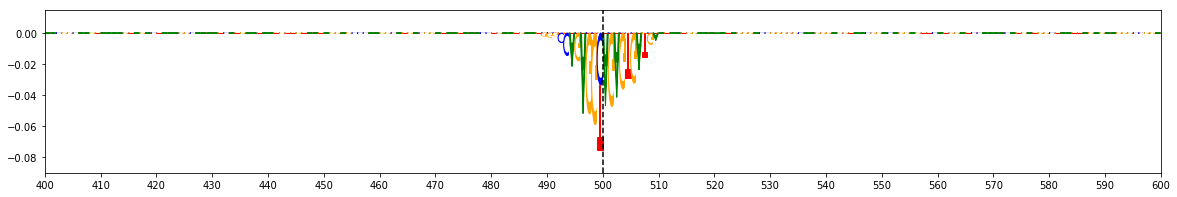


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7940536   ||    chr11 : 47373688 - 47373689   ||    Locus: 29   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.79E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0786   ||   Center / 200bp : 0.6509
Noneffect Sequence : GCCCTGATTGGCAGTGATTA


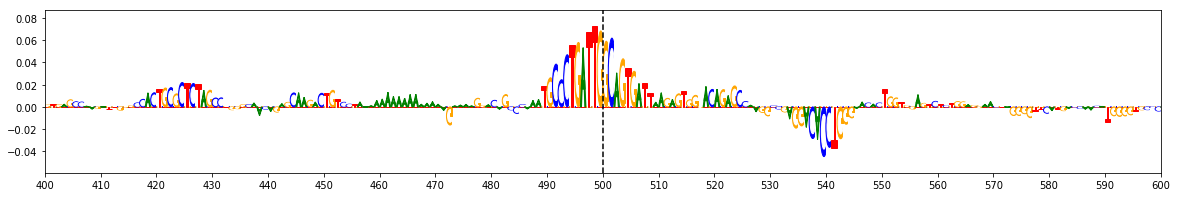

Effect Allele : A   ||   Explain Score : 0.6795   ||   Center / 200bp : 0.5403
Effect Sequence : GCCCTGATTAGCAGTGATTA


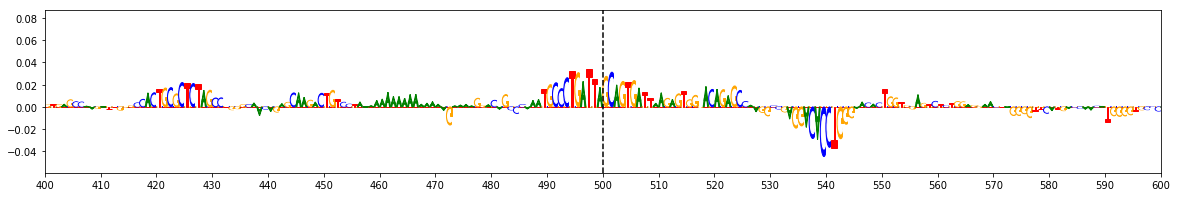

Allele Ratio : 0.63   ||   Allele Difference : -0.3991  ||  ISM Score : -0.7089  ||  deltaSVM Score : -4.0895


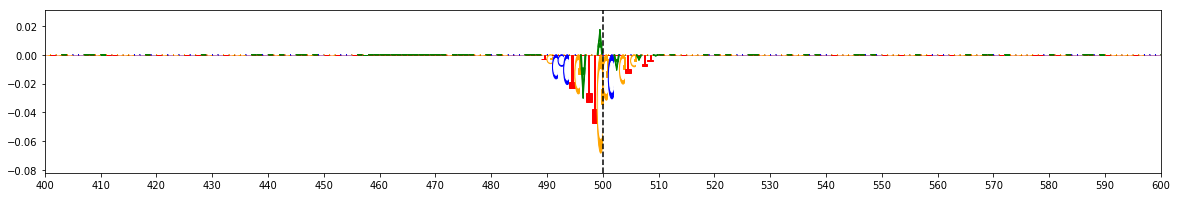


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2737022   ||    chr4 : 89818510 - 89818511   ||    Locus: 591   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  1.53E-07
23andme_PD_hg38 		  5.13E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.4301   ||   Center / 200bp : 0.2743
Noneffect Sequence : GCTCTCTAACACTCCAGAAA


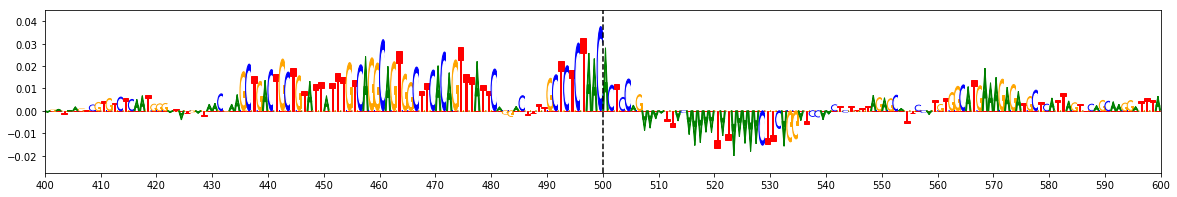

Effect Allele : A   ||   Explain Score : 0.1156   ||   Center / 200bp : 0.0925
Effect Sequence : GCTCTCTAAAACTCCAGAAA


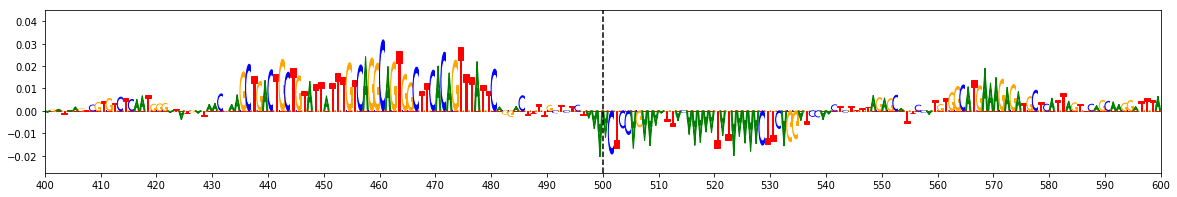

Allele Ratio : 0.2687   ||   Allele Difference : -0.4575  ||  ISM Score : -0.7131  ||  deltaSVM Score : -4.1398


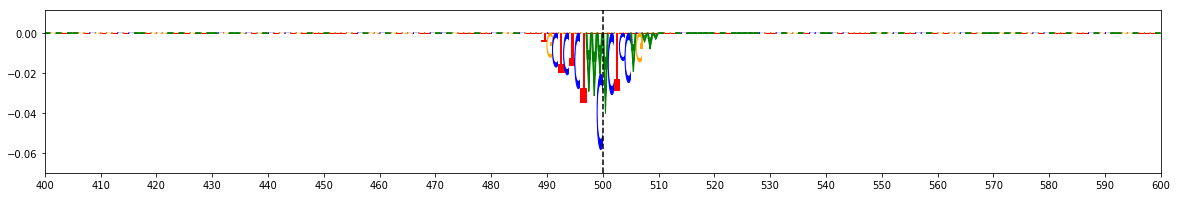


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 643   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.44E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.2951   ||   Center / 200bp : 0.5255
Noneffect Sequence : GAGCAGCAAACAAAGGCTAA


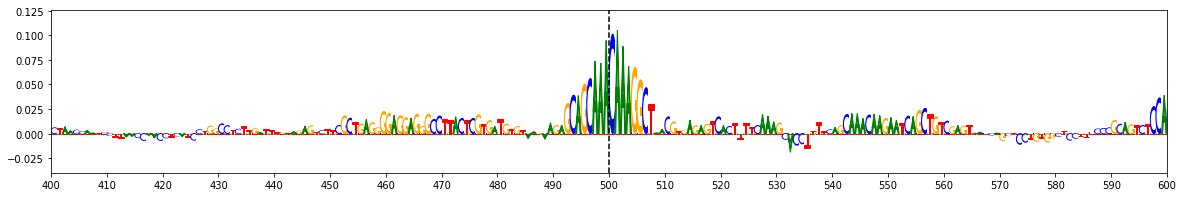

Effect Allele : C   ||   Explain Score : 0.6779   ||   Center / 200bp : 0.3661
Effect Sequence : GAGCAGCAACCAAAGGCTAA


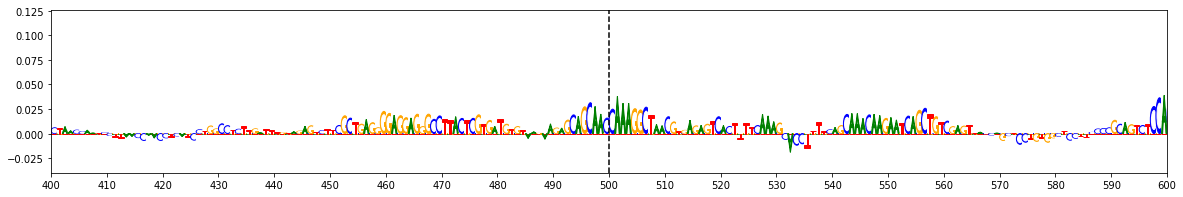

Allele Ratio : 0.5234   ||   Allele Difference : -0.6173  ||  ISM Score : -0.9698  ||  deltaSVM Score : -5.5313


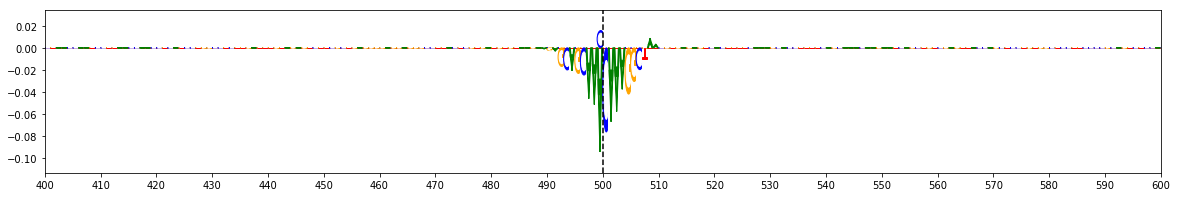


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 205   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 4.1968   ||   Center / 200bp : 0.892
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


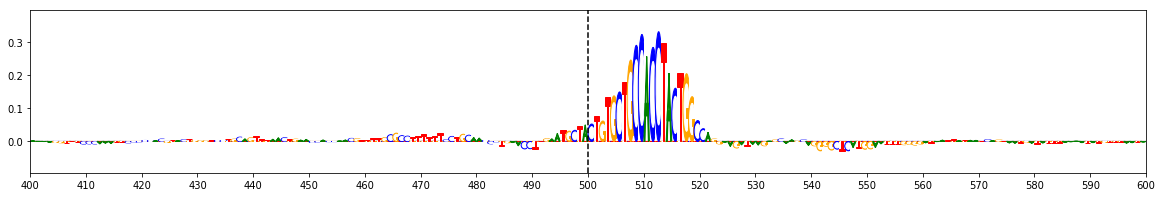

Effect Allele : C   ||   Explain Score : 3.7981   ||   Center / 200bp : 0.882
Effect Sequence : TTGAATGCTCCTGTGCTGCC


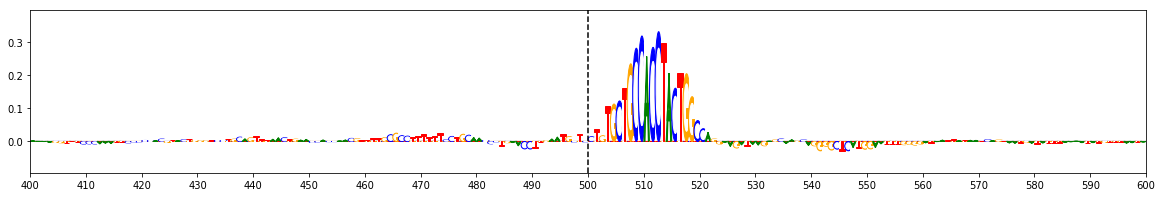

Allele Ratio : 0.905   ||   Allele Difference : -0.4017  ||  ISM Score : -0.6292  ||  deltaSVM Score : -3.6145


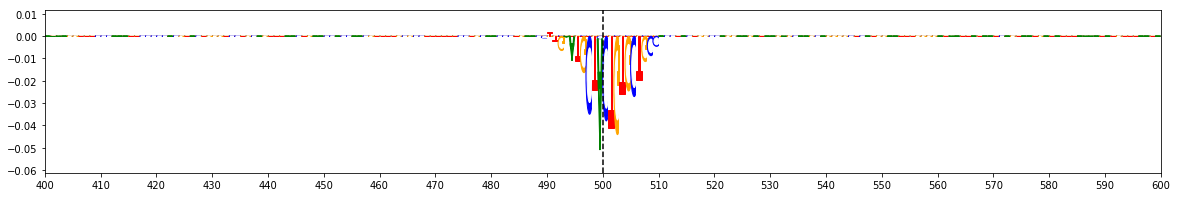


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 411   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.781   ||   Center / 200bp : 0.5343
Noneffect Sequence : CAACACGGGGCGGGCACAAG


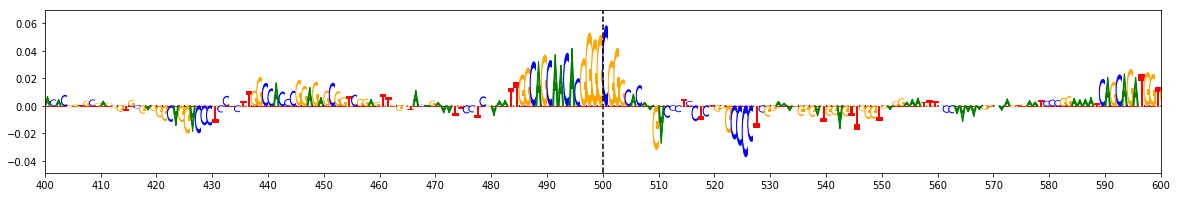

Effect Allele : T   ||   Explain Score : 0.4241   ||   Center / 200bp : 0.3834
Effect Sequence : CAACACGGGTCGGGCACAAG


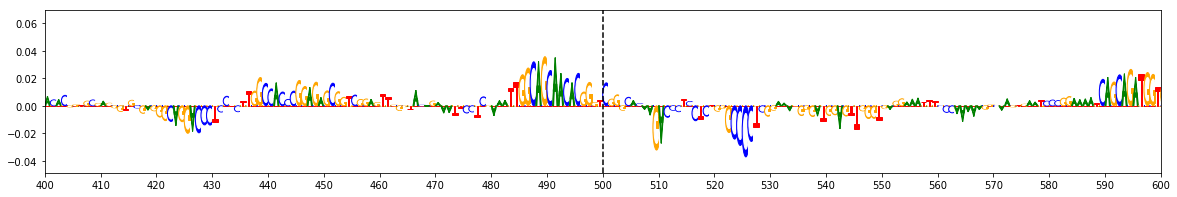

Allele Ratio : 0.543   ||   Allele Difference : -0.3677  ||  ISM Score : -0.5871  ||  deltaSVM Score : -3.3716


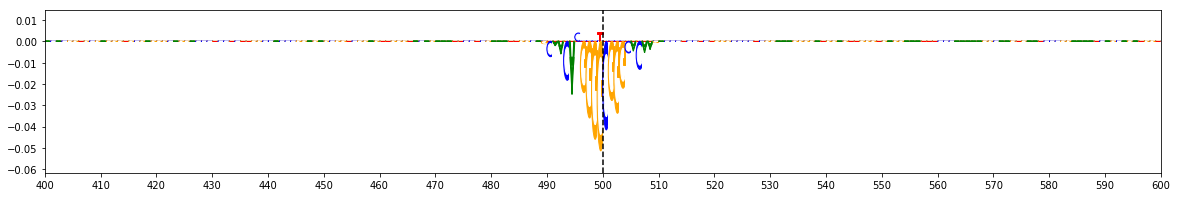


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10898439   ||    chr11 : 86148440 - 86148441   ||    Locus: 60   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.22E-14
Alzheimers_Kunkle_2019 		  2.99E-09
Alzheimers_Lambert_2013 	  2.96E-09

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.5835   ||   Center / 200bp : 0.5112
Noneffect Sequence : GTTAGCAGGCAGAATAAGAG


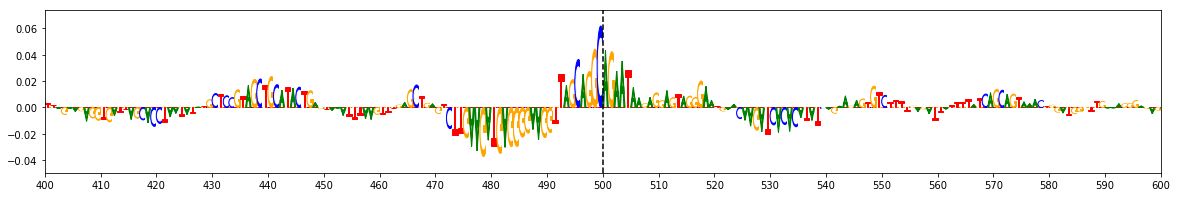

Effect Allele : G   ||   Explain Score : 0.3069   ||   Center / 200bp : 0.3549
Effect Sequence : GTTAGCAGGGAGAATAAGAG


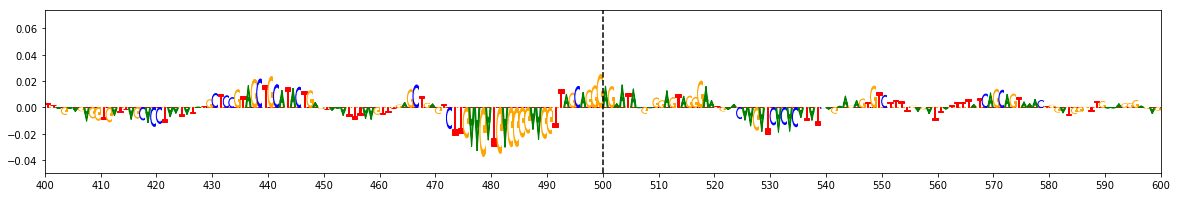

Allele Ratio : 0.526   ||   Allele Difference : -0.2861  ||  ISM Score : -0.4452  ||  deltaSVM Score : -2.5724


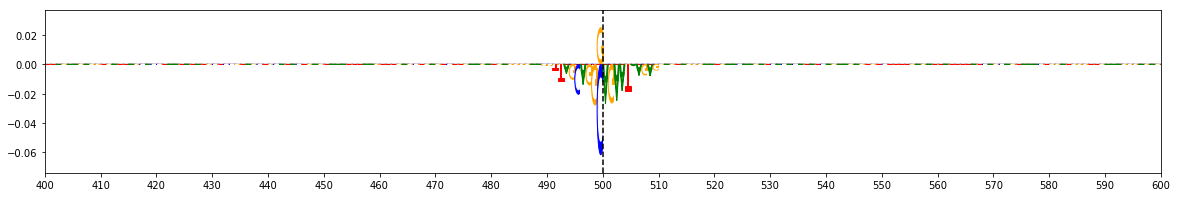


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6503457   ||    chr17 : 46130945 - 46130946   ||    Locus: 343   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  5.17E-21
Parkinsons_Pankratz_2012 	  2.80E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.4732   ||   Center / 200bp : 0.3422
Noneffect Sequence : GCACAAGAGGAAAGCAAAAC


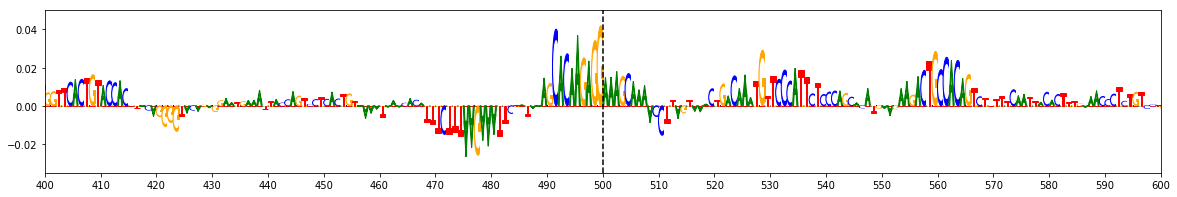

Effect Allele : T   ||   Explain Score : 0.1678   ||   Center / 200bp : 0.1557
Effect Sequence : GCACAAGAGTAAAGCAAAAC


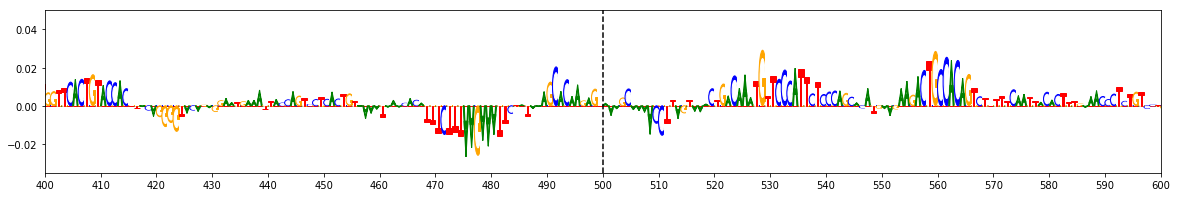

Allele Ratio : 0.3546   ||   Allele Difference : -0.3301  ||  ISM Score : -0.5198  ||  deltaSVM Score : -3.0374


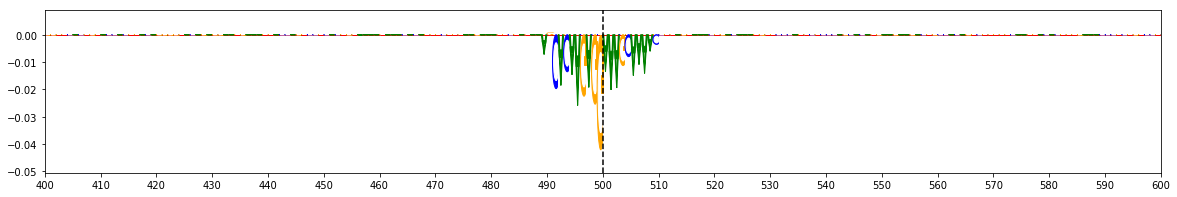


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17689824   ||    chr17 : 45827030 - 45827031   ||    Locus: 190   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.33E-22
Parkinsons_Pankratz_2012 	  1.21E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6567   ||   Center / 200bp : 0.428
Noneffect Sequence : AAGAGGGAGCTTAAAGCCAG


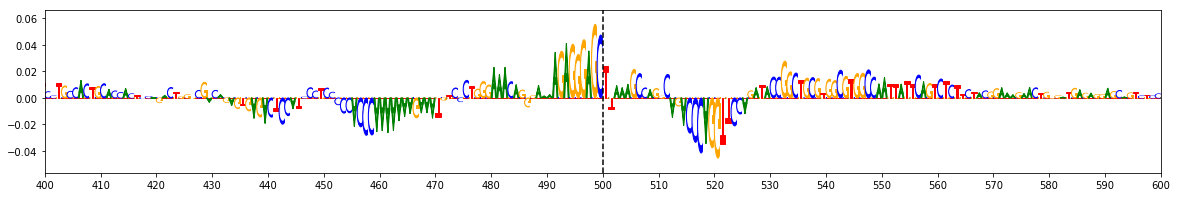

Effect Allele : T   ||   Explain Score : 0.3016   ||   Center / 200bp : 0.2557
Effect Sequence : AAGAGGGAGTTTAAAGCCAG


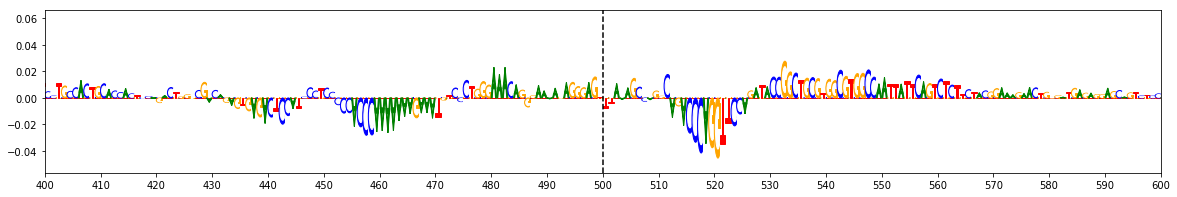

Allele Ratio : 0.4594   ||   Allele Difference : -0.3637  ||  ISM Score : -0.567  ||  deltaSVM Score : -3.364


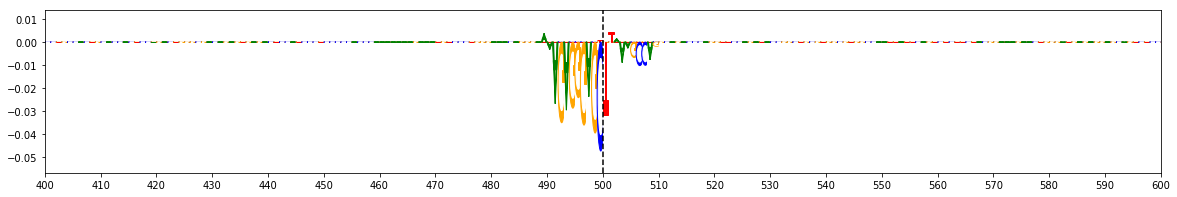


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
294  chr17   46003041   46003042  17_46003042      G         C   .      .   
204  chr17   45852666   45852667   rs62054825      G         A   G      A   
471   chr2   95074354   95074355    rs7585473      T         G   T      G   
247  chr17   45914916   45914917   rs55810795      G         A   A    C,G   
178  chr17   45825577   45825578    rs1912151      T         C   C      T   
482   chr2  101762281  101762282    rs2068397      C         A   C      A   
149  chr17   45681375   45681376   rs62055700      T         C   T      C   
11    chr1  232508907  232508908   rs12073680      G         A   A      G   
563   chr4     987143     987144   rs10902762      G         A   G      A   
500   chr2  127117812  127117813    rs3845674      T         G   T    C,G   
354  chr17   46213482   46213483   rs76475191      T         A   T      A   
0     chr1   39878995   39878996    rs7527412      A         G   G    A,T   
360  chr17   46771150   46771151     rs199523      C         A   C      A   
234  chr17   45897109   45897110   rs80346216      T         G   G      T   
667   chr8   22599691   22599692     rs755934      T         G   T      G   
663   chr8   11845330   11845331    rs1736081      T         G   T      G   
313  chr17   46059436   46059437   rs62060787      T         G   G      T   
624   chr4   89836688   89836689    rs2245801      T         C   T      C   
600   chr4   89828891   89828892   rs33965306    NAN       NAN   A      G   
181  chr17   45825722   45825723   rs41280118      T         C   C      T   
175  chr17   45825432   45825433    rs3885075      G         A   A    C,G   
377  chr17   78414789   78414790    rs3744216      G         A   G    A,C   
355  chr17   46213483   46213484   rs78826239      T         A   T      A   
646   chr6  132812798  132812799   rs79333841      G         C   C    G,T   
431  chr19   44912677   44912678    rs7256200      T         G   G    A,T   
513   chr2  134718389  134718390   rs62171393      G         C   C      G   
548   chr3  122459017  122459018   rs55793255      G         A   A      G   
401  chr19    1040765    1040766    rs4147904      A         G   A      G   
644   chr6   27772886   27772887    rs9468223      T         C   C      T   
289  chr17   45992603   45992604   rs78599197      G         C   C    G,T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
27   chr11   47354896   47354897    rs1057233      A         G   G      A   
406  chr19   18475708   18475709   rs10425982      A         T   T      A   
130  chr17    4902141    4902142   rs72835061      A         C   C      A   
645   chr6   47477280   47477281    rs1004173      T         C   C      T   
230  chr17   45896041   45896042  rs113347741      T         C   C      T   
290  chr17   45993178   45993179   rs55662347      G         A   G      A   
321  chr17   46101517   46101518   rs62061810      G         A   G    A,C   
39   chr11   65834088   65834089   rs17854357      C         G   G    C,T   
361  chr17   49299904   49299905    rs2240301      T         C   T      C   
486   chr2  127081957  127081958   rs11690153      C         T   T      C   
150  chr17   45681420   45681421   rs62055701      G         A   G      A   
633   chr5  103101163  103101164      rs34820      G         A   A      G   
238  chr17   45903395   45903396   rs62056802      G         A   A      G   
70   chr12  122836031  122836032   rs12820345      T         G   G      T   
114  chr16   52592638   52592639    rs3112624      G         A   A      G   
101  chr16   31009756   31009757    rs7184567      T         C   C      T   
40   chr11   65888810   65888811     rs656980      A         G   G      A   
134  chr17    4903854    4903855   rs74574706      T         C   C      T   
279  chr17   45976622   45976623   rs62063778      G         A   G      A   
632   chr5  103041308  103041309    rs6881612      T         C   C      T   
344

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: 17_46003042   ||    chr17 : 46003041 - 46003042   ||    Locus: 294   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.18E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.1505   ||  Center / 200bp: 0.204
Effect Sequence: CTCAGCCTCGCAAATTGCTG


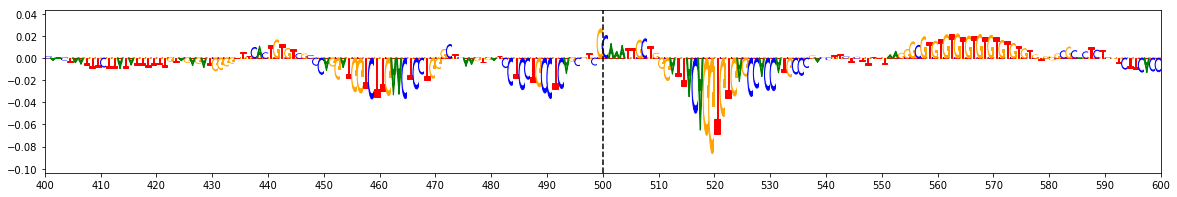

Noneffect Allele: C   ||  Explain Score: 0.0081   ||  Center / 200bp: 0.0137
Noneffect Sequence: CTCAGCCTCCCAAATTGCTG


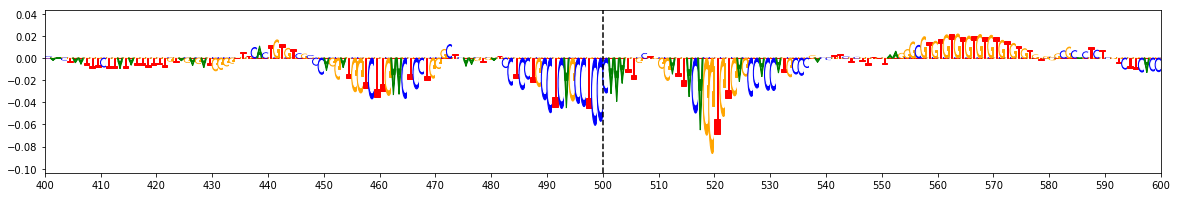

Allele Ratio : 18.4664   ||   Allele Difference : 0.6582  ||  ISM Score : 1.1338  ||  deltaSVM Score : 6.5427


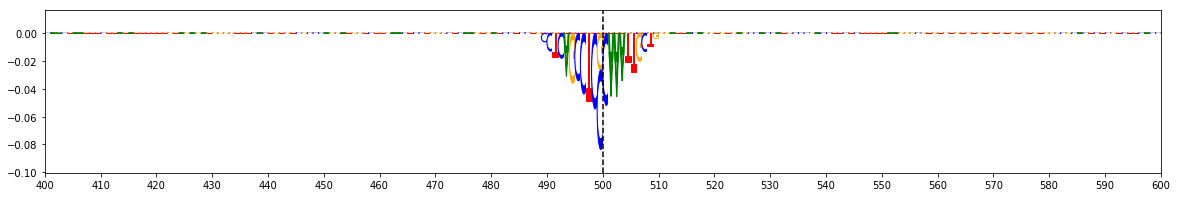


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 204   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.25E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.9464   ||  Center / 200bp: 0.7197
Effect Sequence: TGAGCTCCCGGAAGTGGAGT


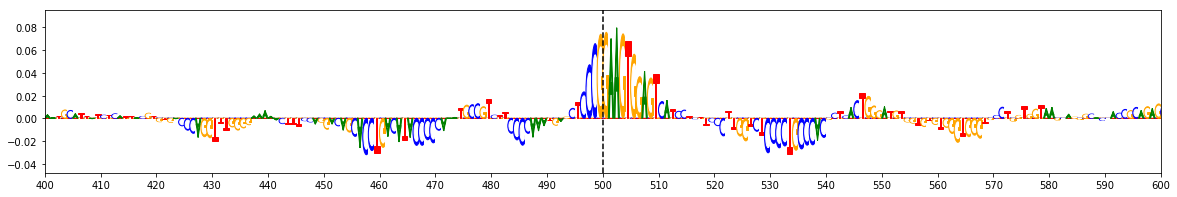

Noneffect Allele: A   ||  Explain Score: 0.2711   ||  Center / 200bp: 0.4235
Noneffect Sequence: TGAGCTCCCAGAAGTGGAGT


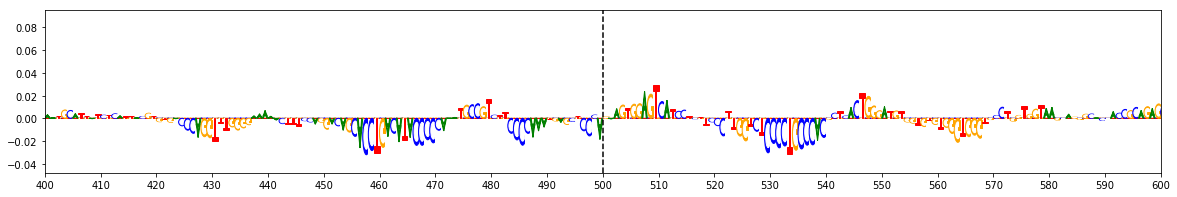

Allele Ratio : 3.4912   ||   Allele Difference : 0.7266  ||  ISM Score : 1.1377  ||  deltaSVM Score : 6.4779


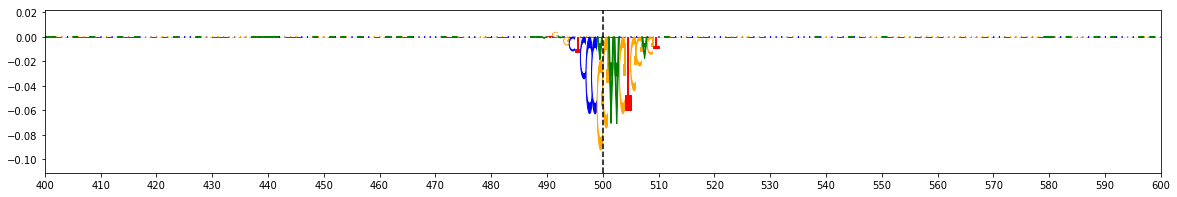


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7585473   ||    chr2 : 95074354 - 95074355   ||    Locus: 471   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.67E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.8634   ||  Center / 200bp: 0.4541
Effect Sequence: TGACCCCATTGTCCTTCCCT


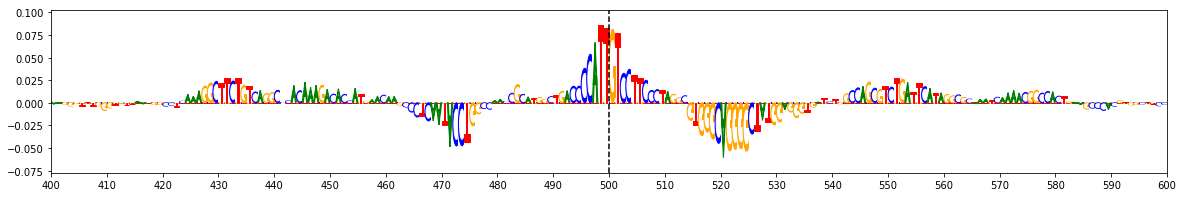

Noneffect Allele: G   ||  Explain Score: 0.1714   ||  Center / 200bp: 0.1418
Noneffect Sequence: TGACCCCATGGTCCTTCCCT


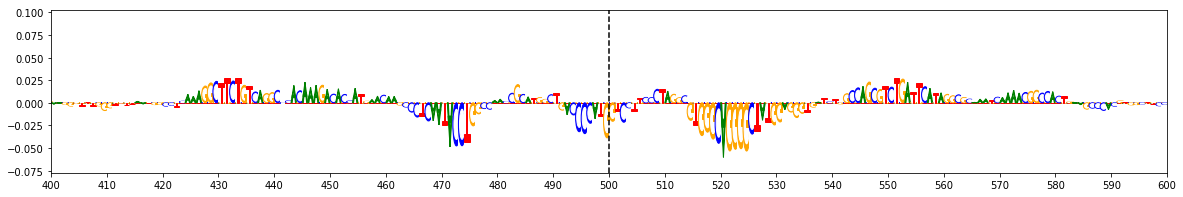

Allele Ratio : 5.0365   ||   Allele Difference : 0.9527  ||  ISM Score : 1.4868  ||  deltaSVM Score : 8.5173


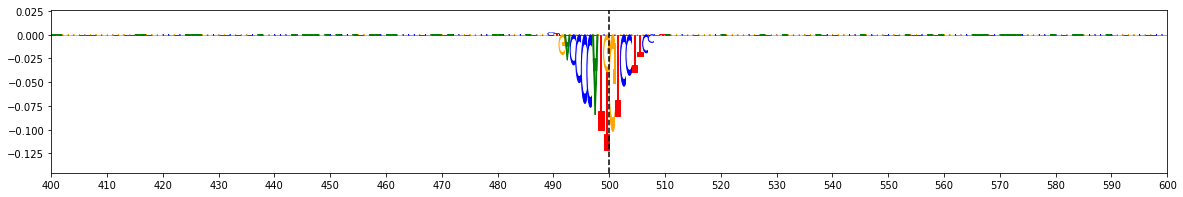


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55810795   ||    chr17 : 45914916 - 45914917   ||    Locus: 247   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.96E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.1305   ||  Center / 200bp: 0.1956
Effect Sequence: AGTTTTTCTGTGTTGCCCAG


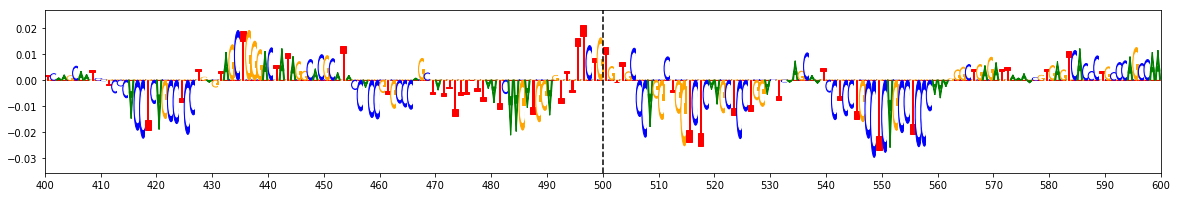

Noneffect Allele: A   ||  Explain Score: 0.0139   ||  Center / 200bp: 0.0252
Noneffect Sequence: AGTTTTTCTATGTTGCCCAG


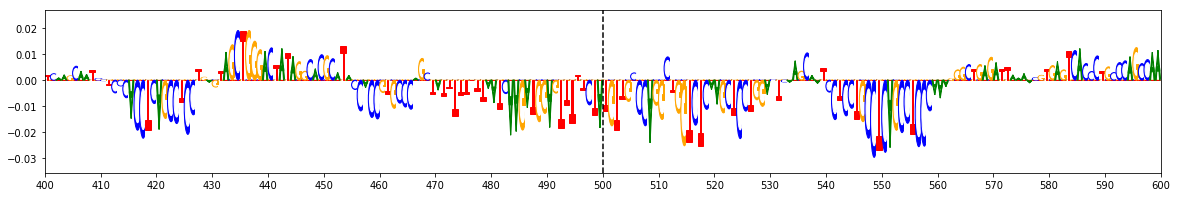

Allele Ratio : 9.3897   ||   Allele Difference : 0.2711  ||  ISM Score : 0.4376  ||  deltaSVM Score : 2.521


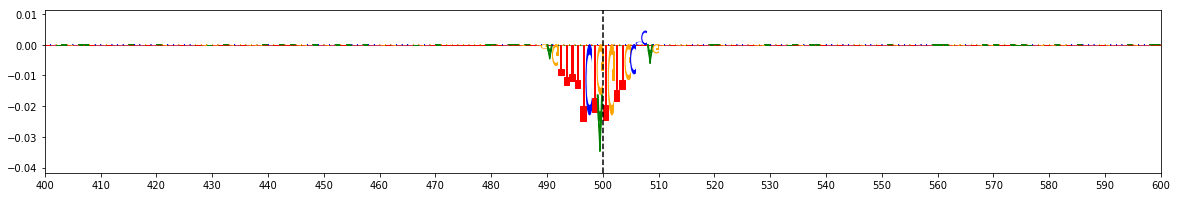


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1912151   ||    chr17 : 45825577 - 45825578   ||    Locus: 178   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22
Parkinsons_Pankratz_2012 	  1.22E-09

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3285   ||  Center / 200bp: 0.2786
Effect Sequence: GGTTCACTGTTCACCGTGTG


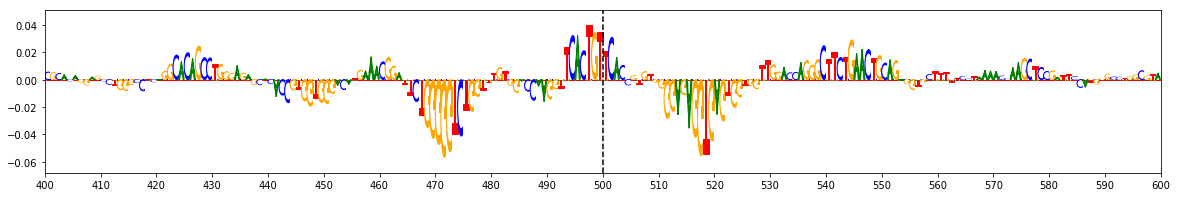

Noneffect Allele: C   ||  Explain Score: 0.0652   ||  Center / 200bp: 0.0712
Noneffect Sequence: GGTTCACTGCTCACCGTGTG


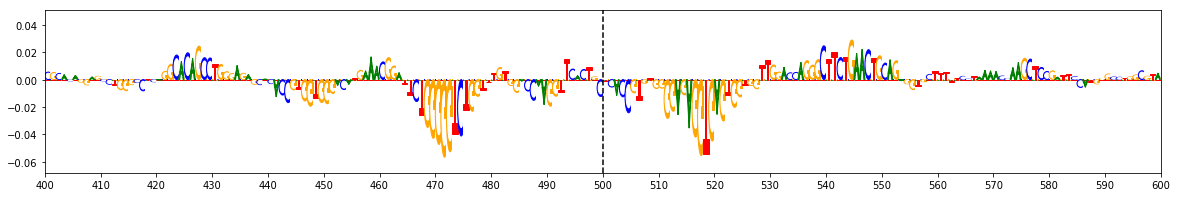

Allele Ratio : 5.0412   ||   Allele Difference : 0.3713  ||  ISM Score : 0.5843  ||  deltaSVM Score : 3.3523


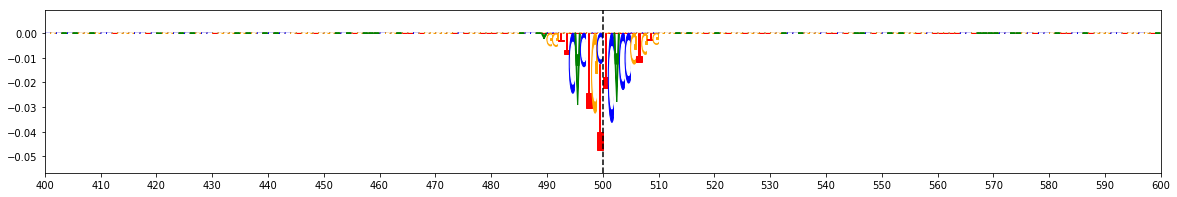


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2068397   ||    chr2 : 101762281 - 101762282   ||    Locus: 482   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.14E-03
Nalls_23andMe 		  1.14E-03

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.3331   ||  Center / 200bp: 0.3847
Effect Sequence: GGCAAATTGCCACACCTAGG


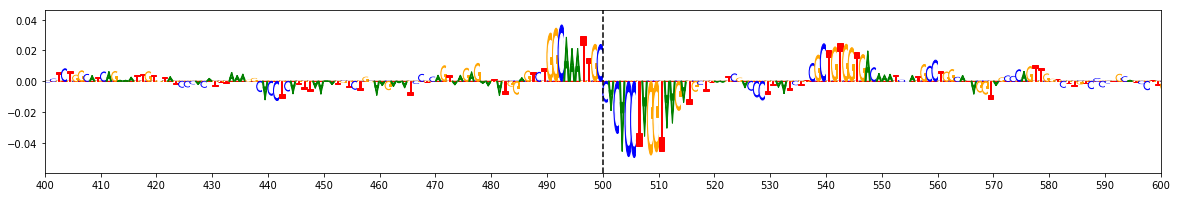

Noneffect Allele: A   ||  Explain Score: 0.0997   ||  Center / 200bp: 0.1568
Noneffect Sequence: GGCAAATTGACACACCTAGG


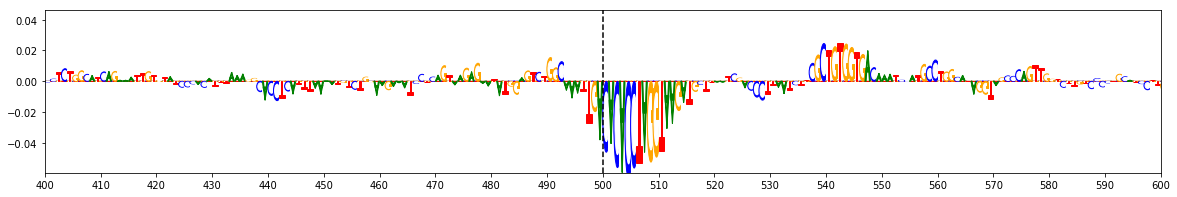

Allele Ratio : 3.339   ||   Allele Difference : 0.4895  ||  ISM Score : 0.7671  ||  deltaSVM Score : 4.3388


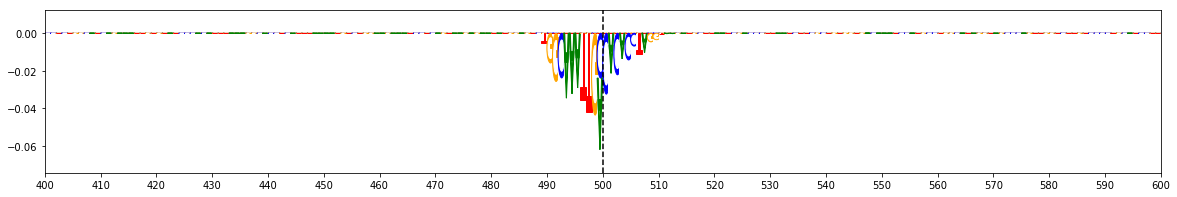


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62055700   ||    chr17 : 45681375 - 45681376   ||    Locus: 149   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.74E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6483   ||  Center / 200bp: 0.5142
Effect Sequence: CACAGGCTCTTTGGTCCTGT


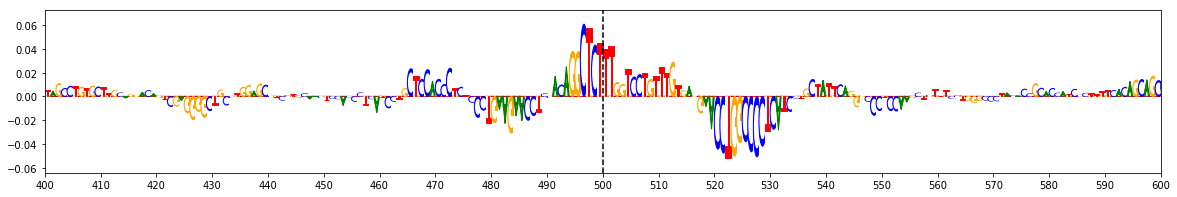

Noneffect Allele: C   ||  Explain Score: 0.2744   ||  Center / 200bp: 0.3095
Noneffect Sequence: CACAGGCTCCTTGGTCCTGT


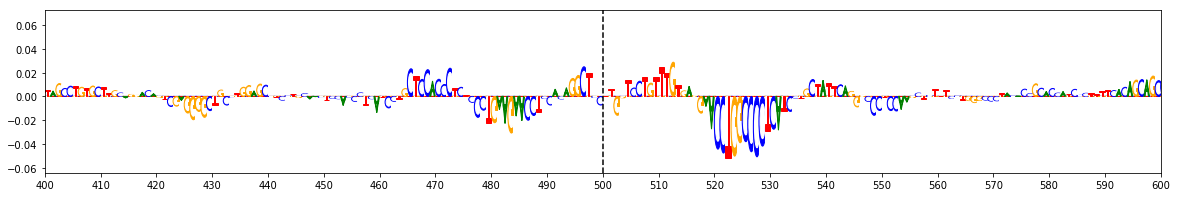

Allele Ratio : 2.3626   ||   Allele Difference : 0.409  ||  ISM Score : 0.6561  ||  deltaSVM Score : 3.7871


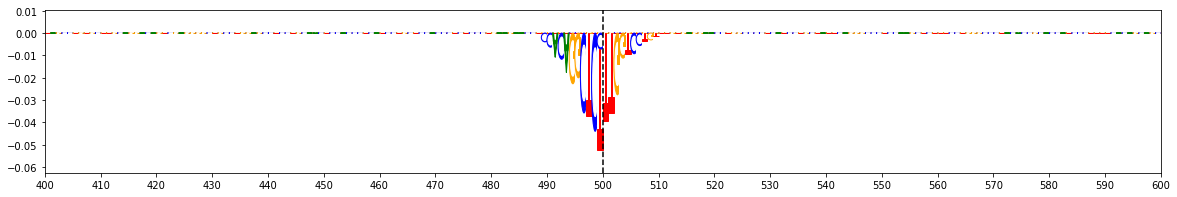


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12073680   ||    chr1 : 232508907 - 232508908   ||    Locus: 11   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.90E-03
Nalls_23andMe 		  3.90E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.1753   ||  Center / 200bp: 0.3481
Effect Sequence: CTGGCCAACGCGGCGAAACC


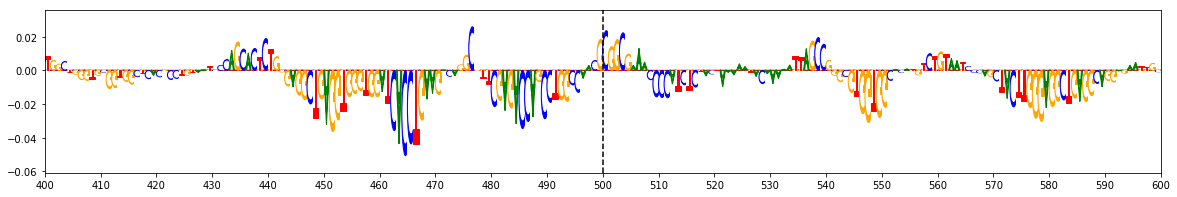

Noneffect Allele: A   ||  Explain Score: 0.0507   ||  Center / 200bp: 0.1339
Noneffect Sequence: CTGGCCAACACGGCGAAACC


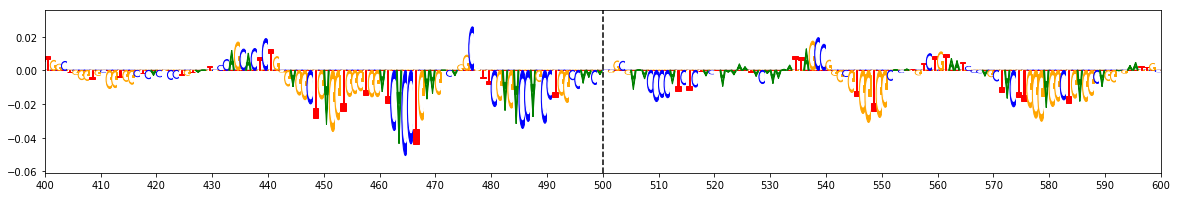

Allele Ratio : 3.457   ||   Allele Difference : 0.1656  ||  ISM Score : 0.2641  ||  deltaSVM Score : 1.5144


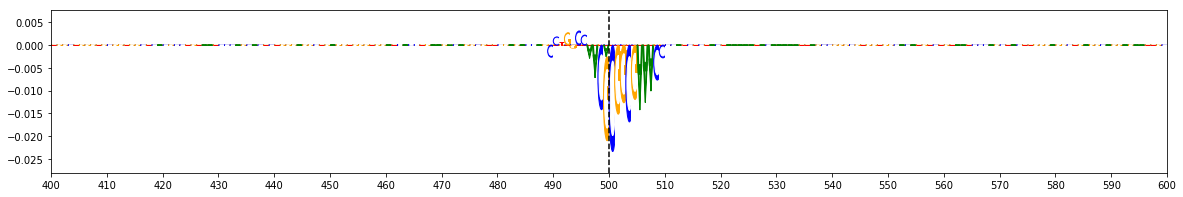


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 563   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3564   ||  Center / 200bp: 0.3926
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


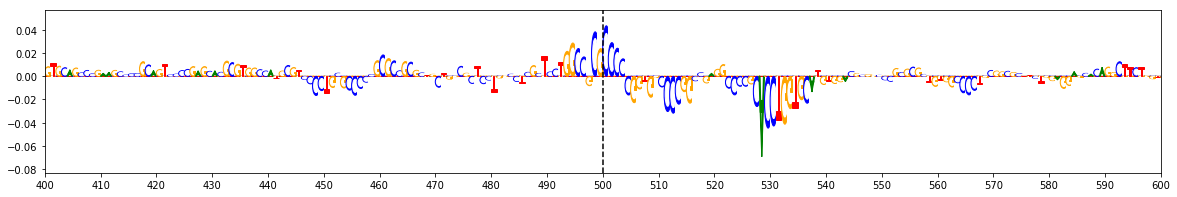

Noneffect Allele: A   ||  Explain Score: 0.1192   ||  Center / 200bp: 0.1754
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


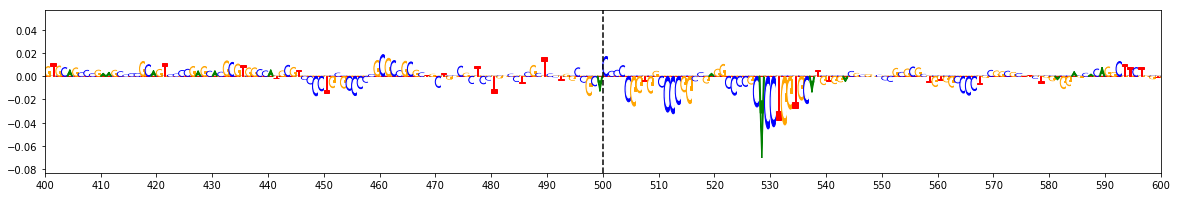

Allele Ratio : 2.9908   ||   Allele Difference : 0.2902  ||  ISM Score : 0.4734  ||  deltaSVM Score : 2.8203


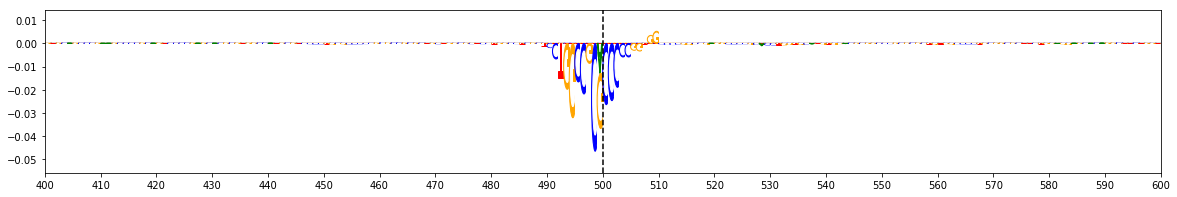


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3845674   ||    chr2 : 127117812 - 127117813   ||    Locus: 500   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.37E-12
Alzheimers_Kunkle_2019 		  6.02E-12
Alzheimers_Lambert_2013 	  6.58E-09

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.4946   ||  Center / 200bp: 0.3414
Effect Sequence: CACGCGCAGTTGTCACCTCC


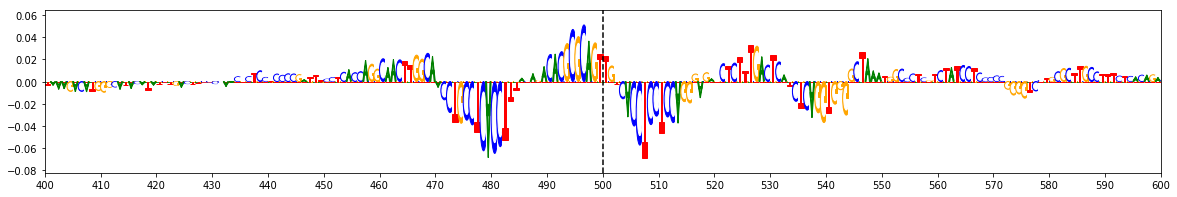

Noneffect Allele: G   ||  Explain Score: 0.1557   ||  Center / 200bp: 0.1407
Noneffect Sequence: CACGCGCAGGTGTCACCTCC


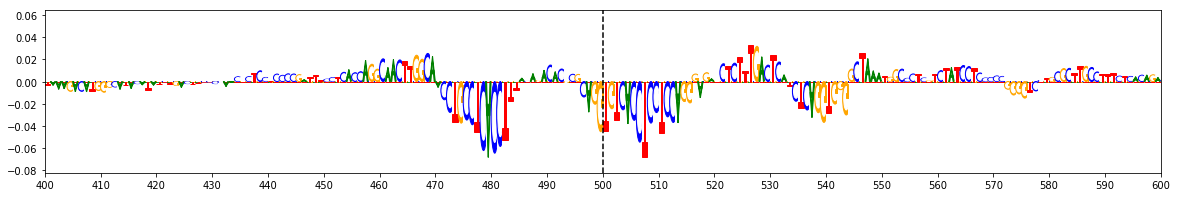

Allele Ratio : 3.1764   ||   Allele Difference : 0.5501  ||  ISM Score : 0.858  ||  deltaSVM Score : 4.9263


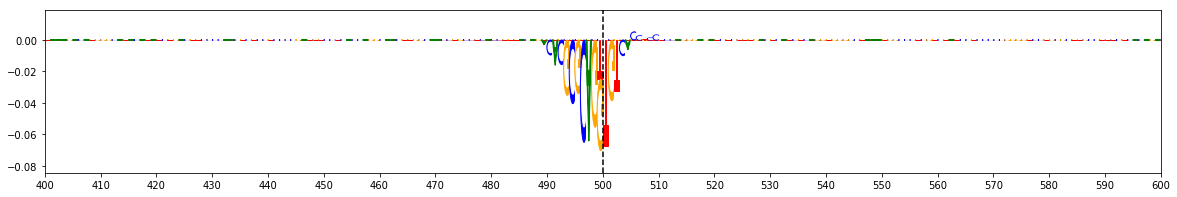


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76475191   ||    chr17 : 46213482 - 46213483   ||    Locus: 354   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4395   ||  Center / 200bp: 0.5994
Effect Sequence: TTTTTTTTTTTTTTTTAGTA


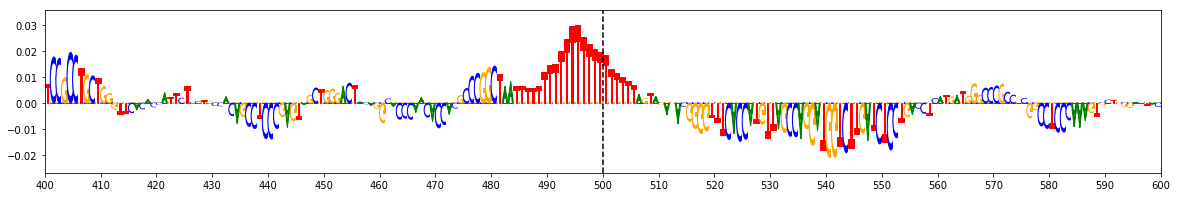

Noneffect Allele: A   ||  Explain Score: 0.2473   ||  Center / 200bp: 0.388
Noneffect Sequence: TTTTTTTTTATTTTTTAGTA


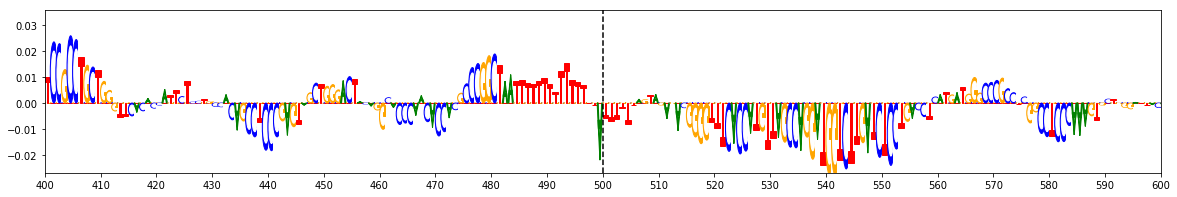

Allele Ratio : 1.7773   ||   Allele Difference : 0.284  ||  ISM Score : 0.322  ||  deltaSVM Score : 12.1185


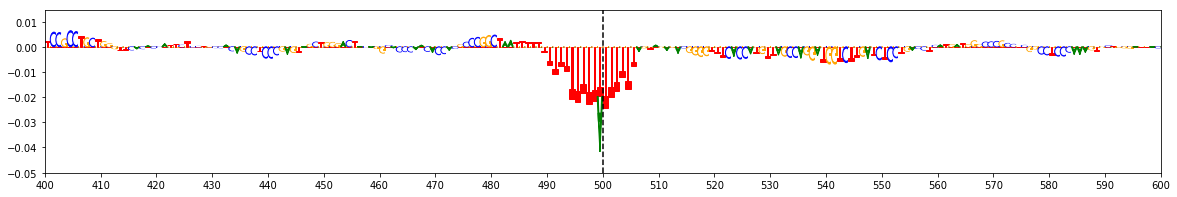


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7527412   ||    chr1 : 39878995 - 39878996   ||    Locus: 0   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.35E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.631   ||  Center / 200bp: 0.6167
Effect Sequence: TGGCCTGGCACAGTGGCTCA


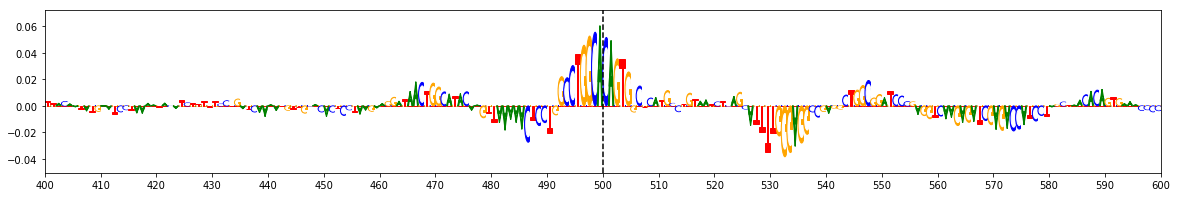

Noneffect Allele: G   ||  Explain Score: 0.3714   ||  Center / 200bp: 0.4864
Noneffect Sequence: TGGCCTGGCGCAGTGGCTCA


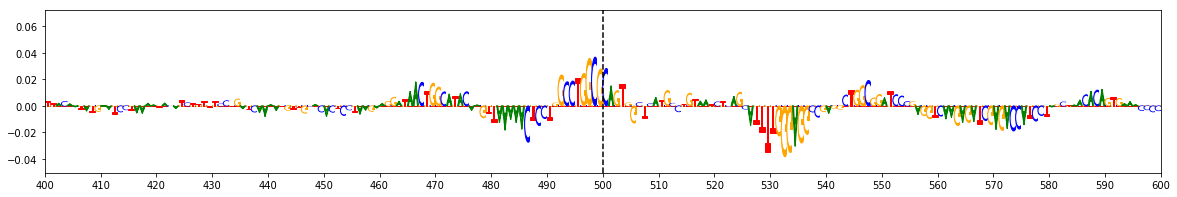

Allele Ratio : 1.6986   ||   Allele Difference : 0.2563  ||  ISM Score : 0.4003  ||  deltaSVM Score : 2.2651


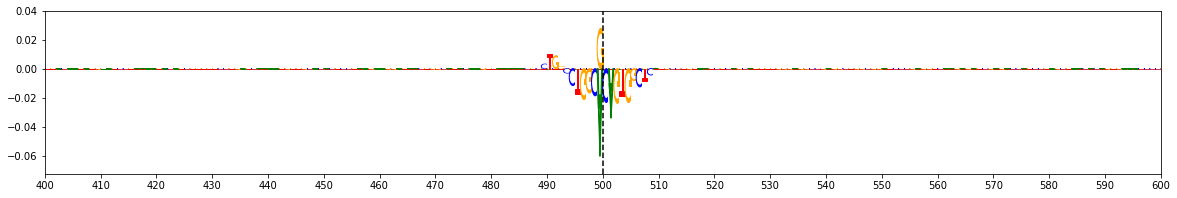


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 360   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 1.3369   ||  Center / 200bp: 0.4795
Effect Sequence: GCCCTCCTGCGCCACCTACA


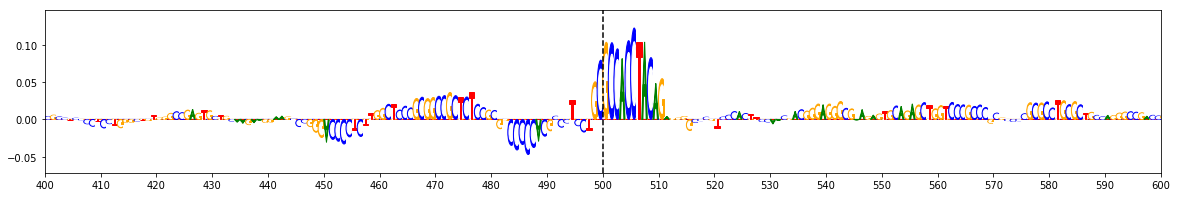

Noneffect Allele: A   ||  Explain Score: 0.6228   ||  Center / 200bp: 0.2999
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


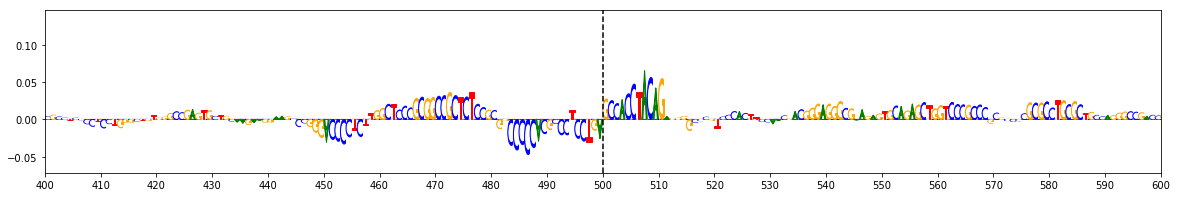

Allele Ratio : 2.1465   ||   Allele Difference : 0.8259  ||  ISM Score : 1.3111  ||  deltaSVM Score : 7.5776


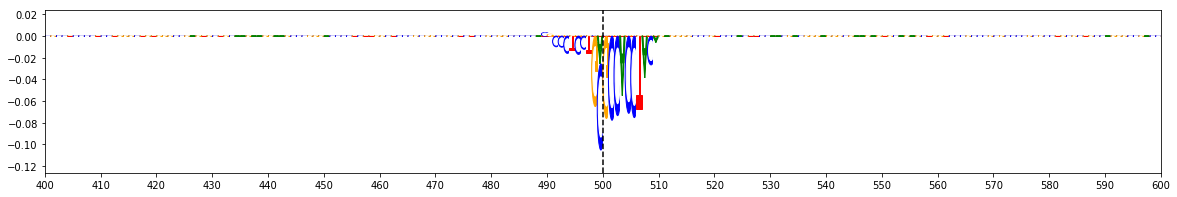


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 234   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.5308   ||  Center / 200bp: 0.5783
Effect Sequence: GCCCGCCGCTAGGGGTTGCA


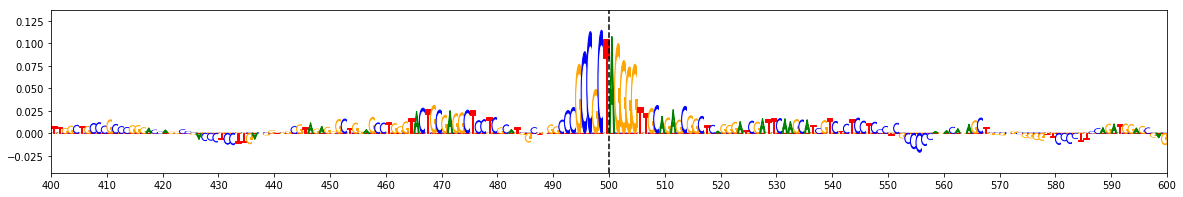

Noneffect Allele: G   ||  Explain Score: 0.8617   ||  Center / 200bp: 0.4359
Noneffect Sequence: GCCCGCCGCGAGGGGTTGCA


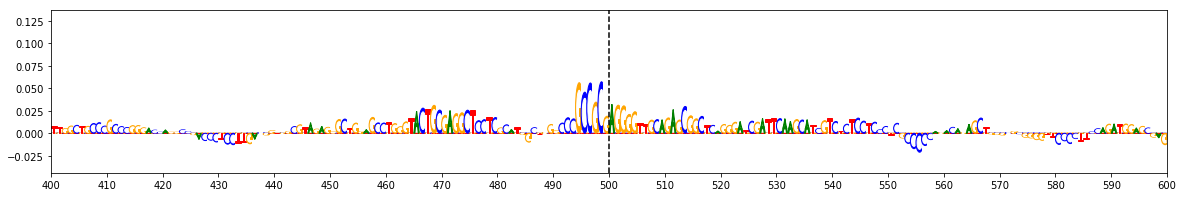

Allele Ratio : 1.7764   ||   Allele Difference : 0.6691  ||  ISM Score : 1.0452  ||  deltaSVM Score : 5.9712


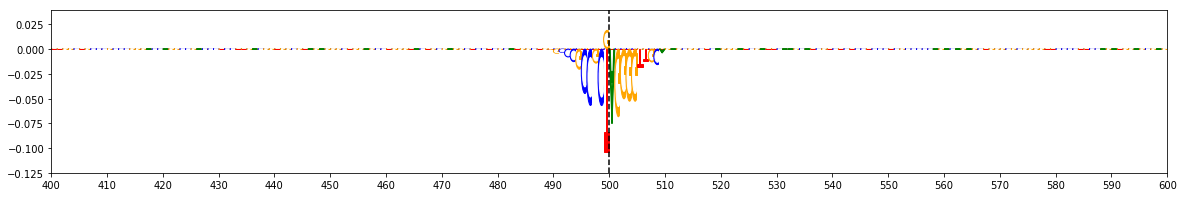


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 667   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.8548   ||  Center / 200bp: 0.5266
Effect Sequence: GCGGCTGCATTGGCCGGGGC


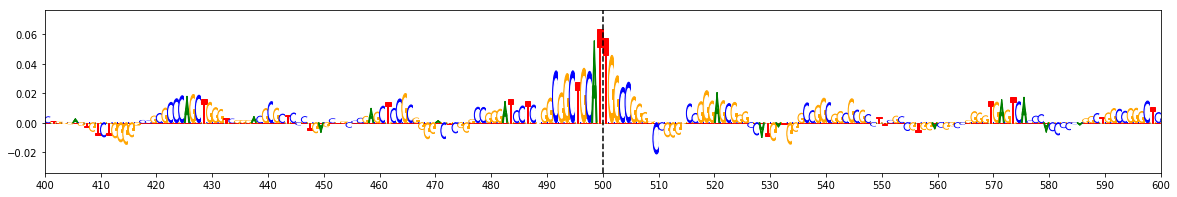

Noneffect Allele: G   ||  Explain Score: 0.44   ||  Center / 200bp: 0.3655
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


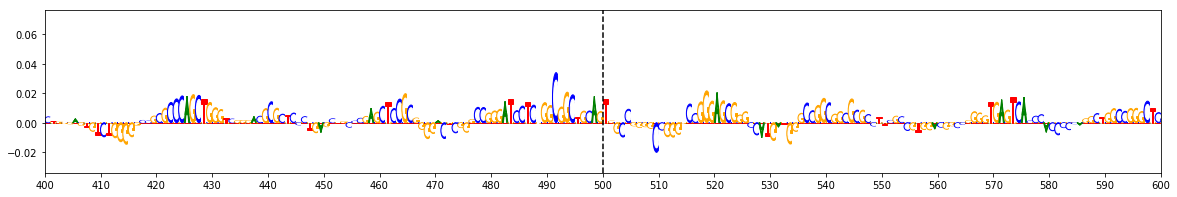

Allele Ratio : 1.9426   ||   Allele Difference : 0.4423  ||  ISM Score : 0.7045  ||  deltaSVM Score : 4.3995


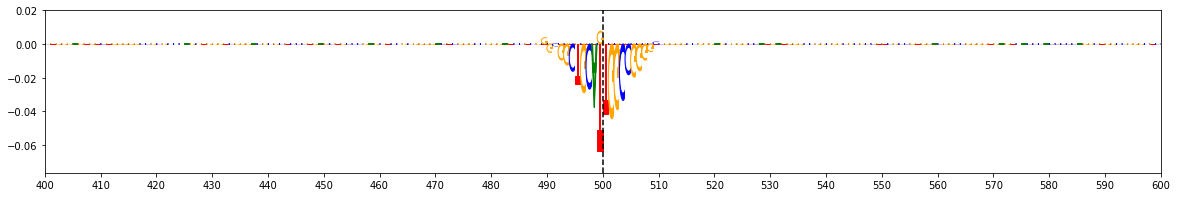


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1736081   ||    chr8 : 11845330 - 11845331   ||    Locus: 663   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.11E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5262   ||  Center / 200bp: 0.6446
Effect Sequence: TCCTGCTGTTGGCCCACTAG


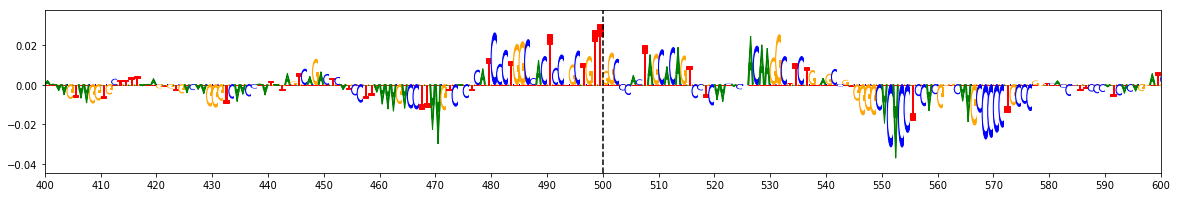

Noneffect Allele: G   ||  Explain Score: 0.3394   ||  Center / 200bp: 0.5405
Noneffect Sequence: TCCTGCTGTGGGCCCACTAG


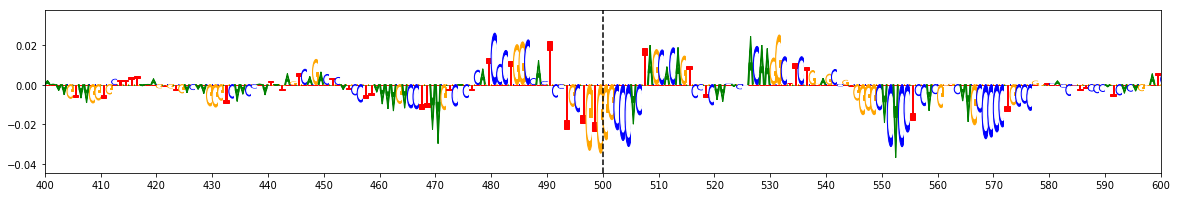

Allele Ratio : 1.5502   ||   Allele Difference : 0.5066  ||  ISM Score : 0.7894  ||  deltaSVM Score : 4.5339


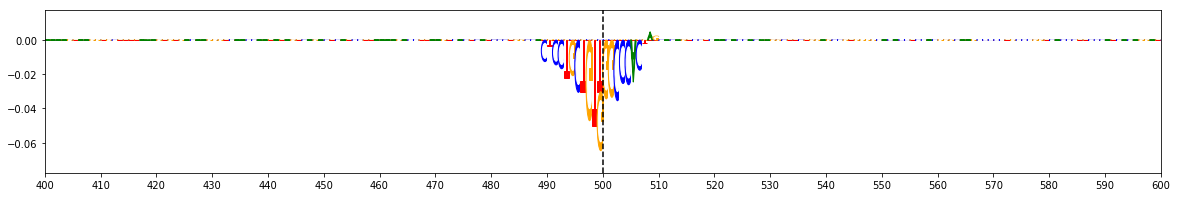


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62060787   ||    chr17 : 46059436 - 46059437   ||    Locus: 313   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.51E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.1468   ||  Center / 200bp: 0.2825
Effect Sequence: GGCCAACATTGTGAAACCCC


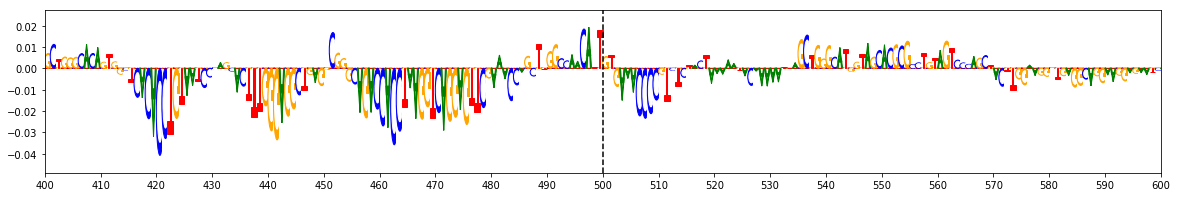

Noneffect Allele: G   ||  Explain Score: 0.0419   ||  Center / 200bp: 0.1011
Noneffect Sequence: GGCCAACATGGTGAAACCCC


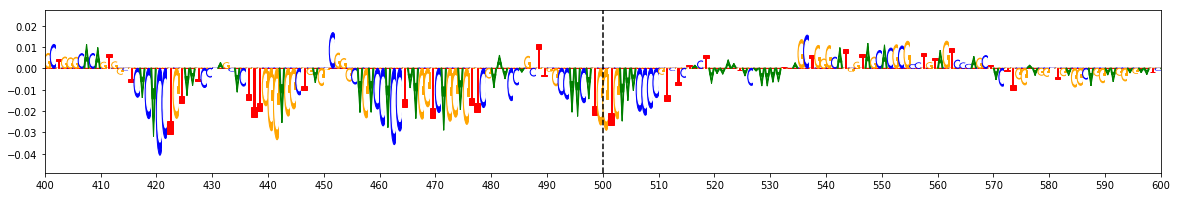

Allele Ratio : 3.5057   ||   Allele Difference : 0.3497  ||  ISM Score : 0.5531  ||  deltaSVM Score : 3.226


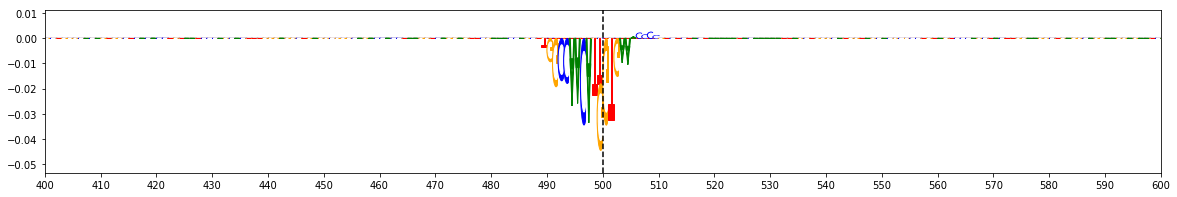


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2245801   ||    chr4 : 89836688 - 89836689   ||    Locus: 624   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  4.28E-14

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5362   ||  Center / 200bp: 0.3684
Effect Sequence: CGTCTCCCATCCGGCGTTCT


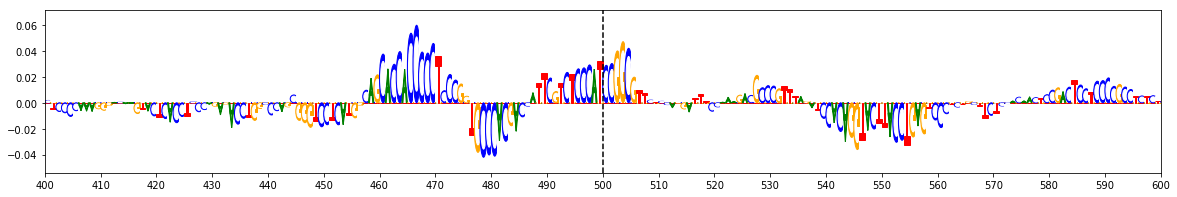

Noneffect Allele: C   ||  Explain Score: 0.2068   ||  Center / 200bp: 0.1839
Noneffect Sequence: CGTCTCCCACCCGGCGTTCT


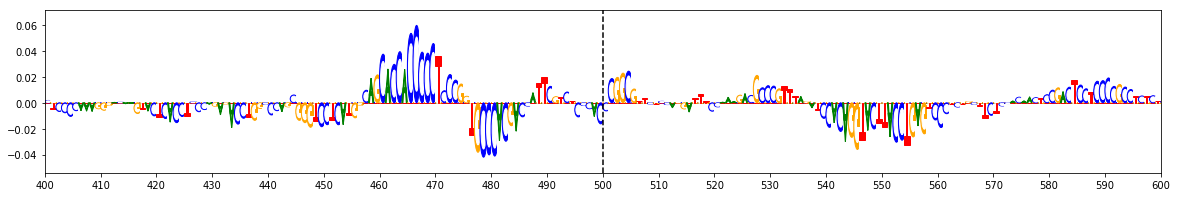

Allele Ratio : 2.5929   ||   Allele Difference : 0.3814  ||  ISM Score : 0.5994  ||  deltaSVM Score : 3.4504


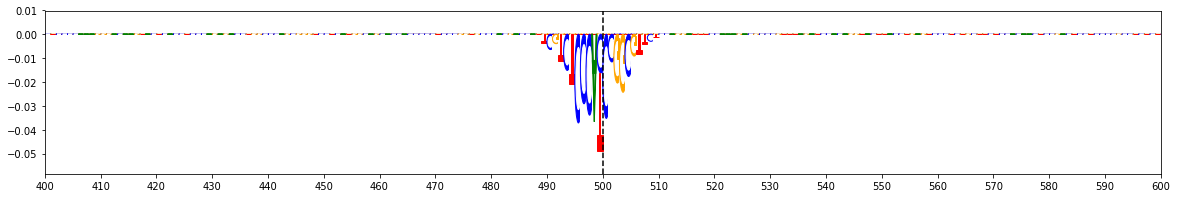


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs33965306   ||    chr4 : 89828891 - 89828892   ||    Locus: 600   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.07E-08

Coloc:  True

Effect Allele: NAN   ||  Explain Score: 0.9134   ||  Center / 200bp: 0.7189
Effect Sequence: CAGTGAGCCGAGATTGTGCC


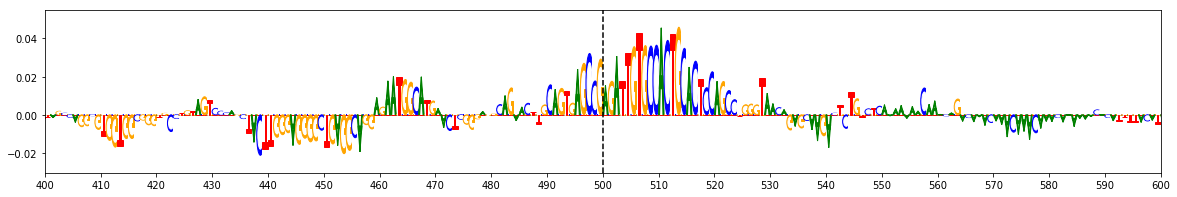

Noneffect Allele: NAN   ||  Explain Score: 0.6961   ||  Center / 200bp: 0.661
Noneffect Sequence: CAGTGAGCCAAGATTGTGCC


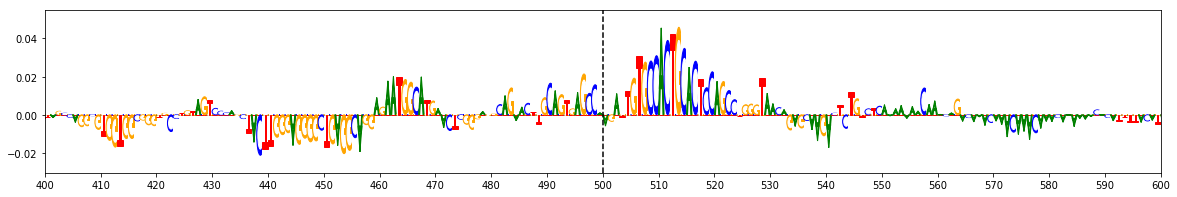

Allele Ratio : 1.3121   ||   Allele Difference : 0.2276  ||  ISM Score : 0.3728  ||  deltaSVM Score : 2.1281


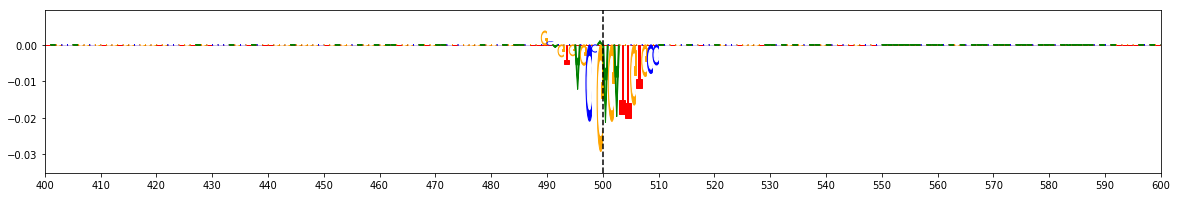


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs41280118   ||    chr17 : 45825722 - 45825723   ||    Locus: 181   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.9086   ||  Center / 200bp: 0.6073
Effect Sequence: GCTCCTCTGTGTGCTGTTGC


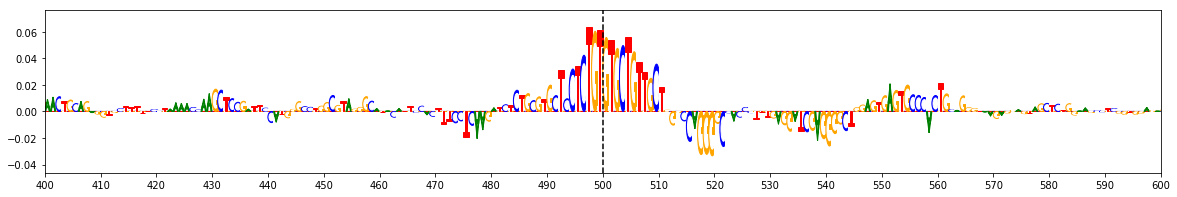

Noneffect Allele: C   ||  Explain Score: 0.5916   ||  Center / 200bp: 0.5054
Noneffect Sequence: GCTCCTCTGCGTGCTGTTGC


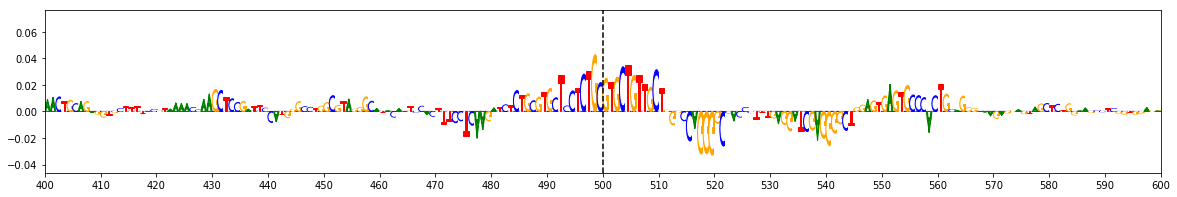

Allele Ratio : 1.5358   ||   Allele Difference : 0.313  ||  ISM Score : 0.5016  ||  deltaSVM Score : 2.7679


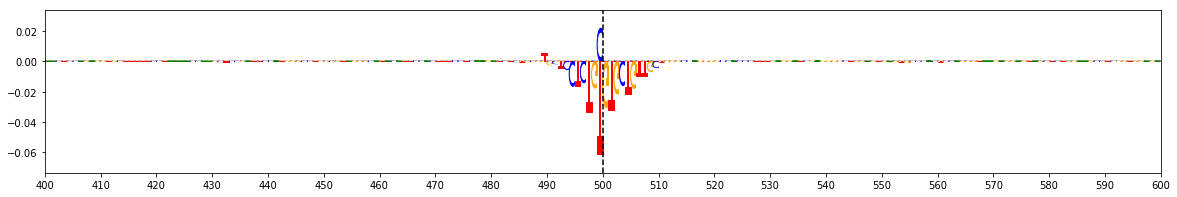


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()